# Image Caption BLIP-2: A new Visual Language Model # 

BLIP-2 is a new visual language model (VLM) capable of multimodal tasks like captioning, visual dialogue and visual question answering.

* BLIP-2 stands for Bootstrapping Language-Image Pre-training with frozen unimodal models.

* In previous approaches we used pre-trained unimodal models for Vision-language pre-training (VLP). This requires aligning visual and textual features, which can be challenging. This is particularly true for frozen unimodal models (like LLMs), which have not seen any images during their pre-training. BLIP address this problem, by introducing a lightweight module called Querying Transformer (Q-Former) that effectively enhances the vision-language model.

* Q-Former is a lightweight transformer that uses learnable query vectors to extract visual features from the frozen image encoder. It acts as an information bottleneck between the frozen image encoder and the frozen LLM, where it feeds the most useful visual feature for the LLM to output the desired text. 

* Key ideas of BLIP-2:

![Merge Architecture for Encoder-Decoder Model](..\images\BLIP-2.png)

In [ ]:
#https://ug.linkedin.com/posts/younes-belkada-b1a903145_fine-tune-large-image-captioning-models-using-activity-7052288723215908865-AKtg

## Load the image captioning dataset

Let's load the image captioning dataset.

In [3]:
import src.utils as plh

base_path = plh.get_project_root()

In [4]:
#Pandas
from pandas import read_parquet

#HuggingFace: Dataset Library
from datasets import Dataset
from datasets import Image

#General Library
import os
import gc

def get_dataset(filetype, **kargs):
    
    """
    Create dataset based on file
    """
    
    filepath = ""
    data_sample = -1
    
    #Read data
    if filetype == 'train':

        filepath = kargs["train_filepath"]
        data_sample = kargs["train_sample"]

    elif filetype == 'valid':

        filepath = kargs["valid_filepath"]
        data_sample = kargs["valid_sample"]
    
    elif filetype == 'test':
        
        filepath = kargs["test_filepath"]
        data_sample = kargs["test_sample"]
        
    if len(filepath) == 0:
        return

    seed = kargs["seed"]
    image_base_path = kargs["image_base_path"]
   
    #print(f'Reading file from path: "{filepath}"')
    db_set = read_parquet(filepath)
    
    if data_sample != -1:
        db_set = db_set.sample(n = data_sample, random_state = seed)

    image_paths = list(image_base_path + '/' + db_set["image_name"])
    captions = list(db_set["caption"])
    
    del [db_set]
    
    db_set = Dataset.from_dict(
                                {
                                    "image": image_paths,
                                    "text": captions,
                                }
                            ).cast_column("image", Image())

    del [image_paths, captions]
    gc.collect() 
    
    return db_set

In [5]:
train_dbset = get_dataset(filetype = 'train', 
                          seed = 44, 
                          train_filepath = os.path.join(base_path, 'data', 'processed', 'train_data_processed.parquet'),
                          train_sample = 10000, 
                          image_base_path = os.path.join(base_path, 'data', 'images'),
                         )

In [6]:
valid_dbset = get_dataset(filetype = 'valid', 
                          seed = 44, 
                          valid_filepath = os.path.join(base_path, 'data', 'processed', 'validate_data_processed.parquet'),
                          valid_sample = 1000, 
                          image_base_path = os.path.join(base_path, 'data', 'images'),
                         )

In [7]:
test_dbset = get_dataset(filetype = 'test', 
                          seed = 44, 
                          test_filepath = os.path.join(base_path, 'data', 'processed', 'test_data_processed.parquet'),
                          test_sample = -1, 
                          image_base_path = os.path.join(base_path, 'data', 'images'),
                         )

Let's retrieve the caption of the first example:

In [8]:
train_dbset[0]["text"]

'black dkgrey gradient sunglass'

And the corresponding image

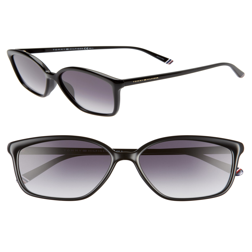

In [9]:
train_dbset[0]["image"].resize((252,252))

## Create PyTorch Dataset

Let's define below the dataset as well as the data collator!

In [10]:
from torch.utils.data import Dataset, DataLoader

class ImageCaptioningDataset(Dataset):
    
    def __init__(self, dataset, processor):
        
        self.dataset = dataset
        self.processor = processor
        #self.new_size = (256,256)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        
        item = self.dataset[idx]
        encoding = self.processor(images = item["image"],#.resize(self.new_size), 
                                  #padding = "max_length", 
                                  return_tensors = "pt"
                                 )
        
        # remove batch dimension
        encoding = {k: v.squeeze() for k, v in encoding.items()}
        encoding["text"] = item["text"]
        
        return encoding

def collate_fn(batch):
    
    # pad the input_ids and attention_mask
    processed_batch = {}
    
    for key in batch[0].keys():
        if key != "text":
            processed_batch[key] = torch.stack([example[key] for example in batch])
        else:
            text_inputs = processor.tokenizer(
                                            [example["text"] for example in batch], 
                                            padding = "max_length" ,#True, 
                                            max_length = 10, #9, #16
                                            return_tensors = "pt",
                                            truncation = True,
                                            )
            processed_batch["input_ids"] = text_inputs["input_ids"]
            processed_batch["attention_mask"] = text_inputs["attention_mask"]
    return processed_batch


## Load processor ##

In [11]:
from transformers import Blip2Processor

checkpoint = 'Salesforce/blip2-opt-2.7b'
processor = Blip2Processor.from_pretrained(checkpoint)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

Now that we have loaded the processor, let's load the dataset and the dataloader:

In [12]:
BATCH_SIZE = 32 #38 #32(Worked) #16(Worked) #56 #64 #128 #512 #1024

In [13]:
train_dataloader = DataLoader(ImageCaptioningDataset(train_dbset, processor), 
                              shuffle = True, 
                              batch_size = BATCH_SIZE, 
                              collate_fn = collate_fn,
                              num_workers  = 2,
                              prefetch_factor  = 2,
                             )

del train_dbset

In [14]:
valid_dataloader = DataLoader(ImageCaptioningDataset(valid_dbset, processor), 
                              batch_size = BATCH_SIZE, 
                              collate_fn = collate_fn,
                              num_workers  = 2,
                              prefetch_factor = 2,
                             )

del valid_dbset

In [15]:
test_dataloader = DataLoader(ImageCaptioningDataset(test_dbset , processor), 
                              batch_size = BATCH_SIZE, 
                              collate_fn = collate_fn,
                              num_workers  = 2,
                              prefetch_factor = 2,
                             )

del test_dbset

In [16]:
gc.collect()

111

# Train model #

## Load model and processor

* Original model "Salesforce/blip2-opt-2.7b" was too large(15.5GB) to fit in the RAM. Even after sucessfully loading model, was not able to train and gave resource issue.
* Used model_id "ybelkada/blip2-opt-2.7b-fp16-sharded" which has weights with Float16 precision(FP16) and model is sharded with each size of 995 MB.

In [13]:
from transformers import Blip2ForConditionalGeneration
import torch

device_map = {
    "query_tokens": 0,
    "vision_model":0,
    "language_model": 1,
    "language_projection": 1,
    "lm_head": 1,
    "qformer": 0,
}
max_memory = {i: "4GB" for i in range(2)} #2 GPU 

model = Blip2ForConditionalGeneration.from_pretrained("ybelkada/blip2-opt-2.7b-fp16-sharded", 
                                                      device_map = device_map,  #"auto", # "balanced_low_0"
                                                      max_memory = max_memory,
                                                      load_in_8bit = True,
                                                      torch_dtype = torch.float16,
                                                     )

#model


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /opt/conda/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda118.so
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 7.5
CUDA SETUP: Detected CUDA version 118
CUDA SETUP: Loading binary /opt/conda/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda118.so...


/opt/conda/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/usr/local/nvidia/lib'), PosixPath('/usr/local/lib/x86_64-linux-gnu'), PosixPath('/usr/local/cuda/lib')}
  warn(msg)


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Next we define our `LoraConfig` object. We explicitly tell 

In [14]:
from peft import LoraConfig, get_peft_model   
    
# Let's define the LoraConfig
config = LoraConfig(
    r = 16, #32, #10, #18, #16, # Lower rank results in fewer trainable parameters.
    lora_alpha = 32,
    lora_dropout = 0.05,
    bias = "none",
    target_modules = ["q_proj", "k_proj"]
)

model = get_peft_model(model, config)
    
model.print_trainable_parameters()

trainable params: 5,242,880 || all params: 3,749,922,816 || trainable%: 0.13981301102065136


In [15]:
#from peft import PeftModel

#peft_model_id = '/kaggle/input/pre-trained-peft-mode'

#If pre-train peft adapater exits load that
#if os.path.exists(peft_model_id):    
#    model = PeftModel.from_pretrained(model, peft_model_id)

## Train the model ##

Let's train the model! Run the simply the cell below for training the model

In [16]:
from accelerate import Accelerator
#import torch

lr = 6e-4 #2e-4 #5e-4 #8e-4
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
#model.gradient_checkpointing_enable()

accelerator = Accelerator()
model, optimizer, train_dataloader, valid_dataloader  = accelerator.prepare(model, optimizer, train_dataloader, valid_dataloader)

In [17]:
#device = "cuda" if torch.cuda.is_available() else "cpu"
device = accelerator.device
print(f'Device: {device}')

Device: cuda


In [17]:
#Eval metric Library
from rouge_score import rouge_scorer, scoring
from evaluate import load

rouge_types = ["rouge1", "rouge2", "rougeL"]
use_stemmer = False
rouge_score_obj = rouge_scorer.RougeScorer(rouge_types = rouge_types, use_stemmer = use_stemmer)
bleu_score_obj = load("bleu")

def compute_metrics(pred_text, labels_text):

    for ref, pred in zip(labels_text, pred_text):

        #ROUGE Score
        output_score = rouge_score_obj.score(prediction = pred.strip(), target = ref.strip())
        rouge_score_aggregator.add_scores(output_score)
        
        #BLEU Score
        bleu_score = {}

        results = bleu_score_obj.compute(predictions = pred_text, references = labels_text, max_order  = 2)
        bleu_score['bleu@2'] = results['bleu']

        results = bleu_score_obj.compute(predictions = pred_text, references = labels_text, max_order  = 1)
        bleu_score['bleu@1'] = results['bleu']

        bleu_score_aggregator.add_scores(bleu_score)

        
    agg_bleu = bleu_score_aggregator.aggregate()
    agg_rouge = rouge_score_aggregator.aggregate()

    return {
        #ROUGE metric
        "rouge1_fmeasure": round(agg_rouge['rouge1'].mid.fmeasure, 2),
        "rouge2_fmeasure": round(agg_rouge['rouge2'].mid.fmeasure, 2),
        "rougeL_fmeasure": round(agg_rouge['rougeL'].mid.fmeasure, 2),
        
        #BLEU metric
        "bleu@1": round(agg_bleu['bleu@1'].mid, 2),
        "bleu@2": round(agg_bleu['bleu@2'].mid, 2),
    }

In [19]:
from tqdm import tqdm

epoch = 10
gradient_accumulation_steps = 2 #8 #4

#model = model.to(device)
for epoch in range(epoch):
    
    print("Epoch:", epoch)
    
    model.train()
    idx = 0
    for batch in tqdm(train_dataloader):
    
        input_ids = batch.pop("input_ids")#.to(device)
        pixel_values = batch.pop("pixel_values").to(torch.float16)#.to(device, torch.float16)

        outputs = model(input_ids = input_ids,
                        pixel_values = pixel_values,
                        labels = input_ids)

        loss = outputs.loss
        loss = loss / gradient_accumulation_steps
        
        #loss.backward()
        accelerator.backward(loss)

        if (idx + 1) % gradient_accumulation_steps == 0:
            
            print(f"Step: {idx+1}, Loss: {outputs.loss.item()}")  #loss

            optimizer.step()
            optimizer.zero_grad()
        
        idx = idx + 1
            
    model.eval()
    
    rouge_score_aggregator = scoring.BootstrapAggregator()
    bleu_score_aggregator = scoring.BootstrapAggregator()

    for batch in tqdm(valid_dataloader):

        input_ids = batch.pop("input_ids")#.to(device)
        pixel_values = batch.pop("pixel_values").to(torch.float16)
    
        predictions = model.generate(pixel_values, max_length = 10)#9 #16
        predictions = processor.batch_decode(predictions, skip_special_tokens = True)
        labels = processor.batch_decode(input_ids, skip_special_tokens = True)

        eval_metric = compute_metrics(predictions, labels) 
    
    print(f"Epoch {epoch}: Eval metric on valid dbset:", eval_metric)

Epoch: 0


  1%|          | 2/313 [00:33<1:16:39, 14.79s/it]

Step: 2, Loss: 6.52734375


  1%|▏         | 4/313 [00:48<51:30, 10.00s/it]  

Step: 4, Loss: 6.203125


  2%|▏         | 6/313 [01:03<46:43,  9.13s/it]

Step: 6, Loss: 5.97265625


  3%|▎         | 8/313 [01:18<43:06,  8.48s/it]

Step: 8, Loss: 5.671875


  3%|▎         | 10/313 [01:32<41:30,  8.22s/it]

Step: 10, Loss: 5.3359375


  4%|▍         | 12/313 [01:48<41:13,  8.22s/it]

Step: 12, Loss: 5.08984375


  4%|▍         | 14/313 [02:02<39:23,  7.90s/it]

Step: 14, Loss: 5.453125


  5%|▌         | 16/313 [02:16<39:27,  7.97s/it]

Step: 16, Loss: 4.859375


  6%|▌         | 18/313 [02:31<38:24,  7.81s/it]

Step: 18, Loss: 4.4609375


  6%|▋         | 20/313 [02:45<38:37,  7.91s/it]

Step: 20, Loss: 4.390625


  7%|▋         | 22/313 [02:59<37:49,  7.80s/it]

Step: 22, Loss: 4.33203125


  8%|▊         | 24/313 [03:15<38:46,  8.05s/it]

Step: 24, Loss: 4.4609375


  8%|▊         | 26/313 [03:29<37:38,  7.87s/it]

Step: 26, Loss: 4.2578125


  9%|▉         | 28/313 [03:43<36:23,  7.66s/it]

Step: 28, Loss: 4.3203125


 10%|▉         | 30/313 [03:57<35:57,  7.62s/it]

Step: 30, Loss: 4.12890625


 10%|█         | 32/313 [04:12<35:53,  7.66s/it]

Step: 32, Loss: 4.046875


 11%|█         | 34/313 [04:26<35:28,  7.63s/it]

Step: 34, Loss: 3.8125


 12%|█▏        | 36/313 [04:40<34:41,  7.51s/it]

Step: 36, Loss: 3.9921875


 12%|█▏        | 38/313 [04:56<36:40,  8.00s/it]

Step: 38, Loss: 3.83984375


 13%|█▎        | 40/313 [05:11<35:58,  7.91s/it]

Step: 40, Loss: 3.939453125


 13%|█▎        | 42/313 [05:25<36:00,  7.97s/it]

Step: 42, Loss: 4.15234375


 14%|█▍        | 44/313 [05:39<34:59,  7.80s/it]

Step: 44, Loss: 3.572265625


 15%|█▍        | 46/313 [05:54<35:16,  7.93s/it]

Step: 46, Loss: 4.1484375


 15%|█▌        | 48/313 [06:09<34:45,  7.87s/it]

Step: 48, Loss: 3.970703125


 16%|█▌        | 50/313 [06:23<34:00,  7.76s/it]

Step: 50, Loss: 3.595703125


 17%|█▋        | 52/313 [06:37<33:38,  7.73s/it]

Step: 52, Loss: 3.85546875


 17%|█▋        | 54/313 [06:52<34:23,  7.97s/it]

Step: 54, Loss: 3.6953125


 18%|█▊        | 56/313 [07:06<33:31,  7.83s/it]

Step: 56, Loss: 3.85546875


 19%|█▊        | 58/313 [07:20<32:29,  7.65s/it]

Step: 58, Loss: 3.419921875


 19%|█▉        | 60/313 [07:35<33:05,  7.85s/it]

Step: 60, Loss: 3.689453125


 20%|█▉        | 62/313 [07:50<33:30,  8.01s/it]

Step: 62, Loss: 3.828125


 20%|██        | 64/313 [08:05<33:18,  8.02s/it]

Step: 64, Loss: 3.642578125


 21%|██        | 66/313 [08:19<32:50,  7.98s/it]

Step: 66, Loss: 3.451171875


 22%|██▏       | 68/313 [08:35<33:41,  8.25s/it]

Step: 68, Loss: 3.4765625


 22%|██▏       | 70/313 [08:49<31:20,  7.74s/it]

Step: 70, Loss: 3.771484375


 23%|██▎       | 72/313 [09:05<32:56,  8.20s/it]

Step: 72, Loss: 3.564453125


 24%|██▎       | 74/313 [09:19<31:38,  7.94s/it]

Step: 74, Loss: 3.521484375


 24%|██▍       | 76/313 [09:34<31:49,  8.06s/it]

Step: 76, Loss: 3.70703125


 25%|██▍       | 78/313 [09:48<30:21,  7.75s/it]

Step: 78, Loss: 3.216796875


 26%|██▌       | 80/313 [10:02<29:46,  7.67s/it]

Step: 80, Loss: 3.443359375


 26%|██▌       | 82/313 [10:16<29:20,  7.62s/it]

Step: 82, Loss: 3.193359375


 27%|██▋       | 84/313 [10:30<29:02,  7.61s/it]

Step: 84, Loss: 3.470703125


 27%|██▋       | 86/313 [10:45<29:41,  7.85s/it]

Step: 86, Loss: 3.455078125


 28%|██▊       | 88/313 [10:59<28:57,  7.72s/it]

Step: 88, Loss: 3.451171875


 29%|██▉       | 90/313 [11:14<29:27,  7.93s/it]

Step: 90, Loss: 3.470703125


 29%|██▉       | 92/313 [11:28<28:41,  7.79s/it]

Step: 92, Loss: 3.484375


 30%|███       | 94/313 [11:43<29:08,  7.98s/it]

Step: 94, Loss: 3.40625


 31%|███       | 96/313 [11:57<28:44,  7.95s/it]

Step: 96, Loss: 3.115234375


 31%|███▏      | 98/313 [12:11<27:42,  7.73s/it]

Step: 98, Loss: 3.416015625


 32%|███▏      | 100/313 [12:25<27:08,  7.65s/it]

Step: 100, Loss: 3.6484375


 33%|███▎      | 102/313 [12:40<27:25,  7.80s/it]

Step: 102, Loss: 3.373046875


 33%|███▎      | 104/313 [12:54<26:32,  7.62s/it]

Step: 104, Loss: 3.40625


 34%|███▍      | 106/313 [13:09<27:28,  7.97s/it]

Step: 106, Loss: 3.58984375


 35%|███▍      | 108/313 [13:24<27:23,  8.02s/it]

Step: 108, Loss: 3.283203125


 35%|███▌      | 110/313 [13:38<26:29,  7.83s/it]

Step: 110, Loss: 3.69921875


 36%|███▌      | 112/313 [13:53<26:50,  8.01s/it]

Step: 112, Loss: 2.845703125


 36%|███▋      | 114/313 [14:07<25:21,  7.64s/it]

Step: 114, Loss: 3.669921875


 37%|███▋      | 116/313 [14:21<25:29,  7.76s/it]

Step: 116, Loss: 3.5703125


 38%|███▊      | 118/313 [14:36<25:12,  7.76s/it]

Step: 118, Loss: 3.1875


 38%|███▊      | 120/313 [14:50<24:59,  7.77s/it]

Step: 120, Loss: 3.478515625


 39%|███▉      | 122/313 [15:05<24:53,  7.82s/it]

Step: 122, Loss: 3.421875


 40%|███▉      | 124/313 [15:20<25:24,  8.07s/it]

Step: 124, Loss: 3.583984375


 40%|████      | 126/313 [15:35<25:19,  8.12s/it]

Step: 126, Loss: 3.345703125


 41%|████      | 128/313 [15:50<24:41,  8.01s/it]

Step: 128, Loss: 3.095703125


 42%|████▏     | 130/313 [16:04<23:48,  7.81s/it]

Step: 130, Loss: 3.6328125


 42%|████▏     | 132/313 [16:19<23:58,  7.94s/it]

Step: 132, Loss: 3.296875


 43%|████▎     | 134/313 [16:33<23:31,  7.89s/it]

Step: 134, Loss: 3.15234375


 43%|████▎     | 136/313 [16:47<22:26,  7.61s/it]

Step: 136, Loss: 3.2890625


 44%|████▍     | 138/313 [17:02<22:36,  7.75s/it]

Step: 138, Loss: 3.427734375


 45%|████▍     | 140/313 [17:16<21:50,  7.58s/it]

Step: 140, Loss: 3.384765625


 45%|████▌     | 142/313 [17:30<21:40,  7.60s/it]

Step: 142, Loss: 3.458984375


 46%|████▌     | 144/313 [17:44<20:51,  7.41s/it]

Step: 144, Loss: 3.072265625


 47%|████▋     | 146/313 [17:59<20:45,  7.46s/it]

Step: 146, Loss: 3.07421875


 47%|████▋     | 148/313 [18:13<19:58,  7.27s/it]

Step: 148, Loss: 3.353515625


 48%|████▊     | 150/313 [18:26<19:06,  7.03s/it]

Step: 150, Loss: 3.125


 49%|████▊     | 152/313 [18:42<19:32,  7.28s/it]

Step: 152, Loss: 3.53515625


 49%|████▉     | 154/313 [18:56<19:15,  7.26s/it]

Step: 154, Loss: 3.052734375


 50%|████▉     | 156/313 [19:12<19:47,  7.56s/it]

Step: 156, Loss: 3.015625


 50%|█████     | 158/313 [19:27<19:21,  7.49s/it]

Step: 158, Loss: 3.548828125


 51%|█████     | 160/313 [19:42<19:33,  7.67s/it]

Step: 160, Loss: 2.921875


 52%|█████▏    | 162/313 [19:56<18:46,  7.46s/it]

Step: 162, Loss: 3.080078125


 52%|█████▏    | 164/313 [20:11<19:06,  7.70s/it]

Step: 164, Loss: 3.083984375


 53%|█████▎    | 166/313 [20:26<18:48,  7.67s/it]

Step: 166, Loss: 3.3515625


 54%|█████▎    | 168/313 [20:41<18:29,  7.65s/it]

Step: 168, Loss: 3.158203125


 54%|█████▍    | 170/313 [20:55<17:56,  7.52s/it]

Step: 170, Loss: 3.0703125


 55%|█████▍    | 172/313 [21:09<17:36,  7.49s/it]

Step: 172, Loss: 3.515625


 56%|█████▌    | 174/313 [21:24<17:28,  7.54s/it]

Step: 174, Loss: 3.072265625


 56%|█████▌    | 176/313 [21:39<17:43,  7.76s/it]

Step: 176, Loss: 2.86328125


 57%|█████▋    | 178/313 [21:52<16:01,  7.12s/it]

Step: 178, Loss: 3.39453125


 58%|█████▊    | 180/313 [22:06<15:26,  6.97s/it]

Step: 180, Loss: 3.390625


 58%|█████▊    | 182/313 [22:21<15:34,  7.14s/it]

Step: 182, Loss: 3.16796875


 59%|█████▉    | 184/313 [22:36<15:39,  7.28s/it]

Step: 184, Loss: 3.115234375


 59%|█████▉    | 186/313 [22:51<15:27,  7.31s/it]

Step: 186, Loss: 3.244140625


 60%|██████    | 188/313 [23:05<14:49,  7.12s/it]

Step: 188, Loss: 3.189453125


 61%|██████    | 190/313 [23:20<14:26,  7.05s/it]

Step: 190, Loss: 3.2421875


 61%|██████▏   | 192/313 [23:35<14:32,  7.21s/it]

Step: 192, Loss: 3.427734375


 62%|██████▏   | 194/313 [23:51<14:45,  7.44s/it]

Step: 194, Loss: 2.857421875


 63%|██████▎   | 196/313 [24:05<14:14,  7.31s/it]

Step: 196, Loss: 3.19921875


 63%|██████▎   | 198/313 [24:20<14:09,  7.39s/it]

Step: 198, Loss: 3.337890625


 64%|██████▍   | 200/313 [24:35<14:08,  7.51s/it]

Step: 200, Loss: 2.935546875


 65%|██████▍   | 202/313 [24:50<13:59,  7.56s/it]

Step: 202, Loss: 3.25390625


 65%|██████▌   | 204/313 [25:05<13:43,  7.55s/it]

Step: 204, Loss: 3.033203125


 66%|██████▌   | 206/313 [25:19<13:01,  7.30s/it]

Step: 206, Loss: 3.265625


 66%|██████▋   | 208/313 [25:33<12:56,  7.40s/it]

Step: 208, Loss: 2.92578125


 67%|██████▋   | 210/313 [25:48<12:29,  7.27s/it]

Step: 210, Loss: 3.24609375


 68%|██████▊   | 212/313 [26:03<12:36,  7.49s/it]

Step: 212, Loss: 2.806640625


 68%|██████▊   | 214/313 [26:17<12:14,  7.42s/it]

Step: 214, Loss: 3.123046875


 69%|██████▉   | 216/313 [26:32<12:21,  7.64s/it]

Step: 216, Loss: 2.97265625


 70%|██████▉   | 218/313 [26:46<11:55,  7.53s/it]

Step: 218, Loss: 3.109375


 70%|███████   | 220/313 [27:01<11:34,  7.47s/it]

Step: 220, Loss: 2.853515625


 71%|███████   | 222/313 [27:15<11:16,  7.44s/it]

Step: 222, Loss: 2.9140625


 72%|███████▏  | 224/313 [27:30<11:17,  7.61s/it]

Step: 224, Loss: 3.1484375


 72%|███████▏  | 226/313 [27:44<10:58,  7.57s/it]

Step: 226, Loss: 3.259765625


 73%|███████▎  | 228/313 [27:59<10:38,  7.51s/it]

Step: 228, Loss: 3.39453125


 73%|███████▎  | 230/313 [28:13<10:18,  7.46s/it]

Step: 230, Loss: 3.388671875


 74%|███████▍  | 232/313 [28:27<09:52,  7.31s/it]

Step: 232, Loss: 3.28125


 75%|███████▍  | 234/313 [28:42<09:56,  7.56s/it]

Step: 234, Loss: 2.9609375


 75%|███████▌  | 236/313 [28:56<09:38,  7.51s/it]

Step: 236, Loss: 2.8359375


 76%|███████▌  | 238/313 [29:12<09:50,  7.87s/it]

Step: 238, Loss: 3.263671875


 77%|███████▋  | 240/313 [29:27<09:35,  7.89s/it]

Step: 240, Loss: 2.9453125


 77%|███████▋  | 242/313 [29:42<09:32,  8.06s/it]

Step: 242, Loss: 3.349609375


 78%|███████▊  | 244/313 [29:56<08:55,  7.76s/it]

Step: 244, Loss: 3.13671875


 79%|███████▊  | 246/313 [30:11<08:53,  7.97s/it]

Step: 246, Loss: 2.962890625


 79%|███████▉  | 248/313 [30:25<08:25,  7.77s/it]

Step: 248, Loss: 3.412109375


 80%|███████▉  | 250/313 [30:40<08:11,  7.80s/it]

Step: 250, Loss: 3.419921875


 81%|████████  | 252/313 [30:54<07:43,  7.61s/it]

Step: 252, Loss: 3.203125


 81%|████████  | 254/313 [31:08<07:27,  7.58s/it]

Step: 254, Loss: 3.154296875


 82%|████████▏ | 256/313 [31:24<07:32,  7.93s/it]

Step: 256, Loss: 3.640625


 82%|████████▏ | 258/313 [31:37<06:49,  7.45s/it]

Step: 258, Loss: 2.6953125


 83%|████████▎ | 260/313 [31:52<06:44,  7.64s/it]

Step: 260, Loss: 3.201171875


 84%|████████▎ | 262/313 [32:07<06:35,  7.76s/it]

Step: 262, Loss: 2.728515625


 84%|████████▍ | 264/313 [32:22<06:23,  7.83s/it]

Step: 264, Loss: 2.970703125


 85%|████████▍ | 266/313 [32:36<05:59,  7.64s/it]

Step: 266, Loss: 3.22265625


 86%|████████▌ | 268/313 [32:51<06:01,  8.03s/it]

Step: 268, Loss: 3.1953125


 86%|████████▋ | 270/313 [33:06<05:35,  7.81s/it]

Step: 270, Loss: 3.0390625


 87%|████████▋ | 272/313 [33:21<05:31,  8.10s/it]

Step: 272, Loss: 2.673828125


 88%|████████▊ | 274/313 [33:34<04:57,  7.63s/it]

Step: 274, Loss: 3.337890625


 88%|████████▊ | 276/313 [33:50<04:57,  8.04s/it]

Step: 276, Loss: 3.28515625


 89%|████████▉ | 278/313 [34:04<04:34,  7.83s/it]

Step: 278, Loss: 2.69140625


 89%|████████▉ | 280/313 [34:18<04:16,  7.77s/it]

Step: 280, Loss: 3.181640625


 90%|█████████ | 282/313 [34:32<03:59,  7.72s/it]

Step: 282, Loss: 3.400390625


 91%|█████████ | 284/313 [34:46<03:40,  7.61s/it]

Step: 284, Loss: 3.087890625


 91%|█████████▏| 286/313 [35:01<03:31,  7.85s/it]

Step: 286, Loss: 3.208984375


 92%|█████████▏| 288/313 [35:15<03:16,  7.85s/it]

Step: 288, Loss: 3.1328125


 93%|█████████▎| 290/313 [35:30<03:03,  7.99s/it]

Step: 290, Loss: 2.953125


 93%|█████████▎| 292/313 [35:45<02:47,  7.96s/it]

Step: 292, Loss: 3.126953125


 94%|█████████▍| 294/313 [36:00<02:32,  8.04s/it]

Step: 294, Loss: 3.1015625


 95%|█████████▍| 296/313 [36:14<02:13,  7.86s/it]

Step: 296, Loss: 3.095703125


 95%|█████████▌| 298/313 [36:29<02:00,  8.02s/it]

Step: 298, Loss: 3.408203125


 96%|█████████▌| 300/313 [36:43<01:41,  7.82s/it]

Step: 300, Loss: 3.1015625


 96%|█████████▋| 302/313 [36:57<01:25,  7.77s/it]

Step: 302, Loss: 3.3203125


 97%|█████████▋| 304/313 [37:13<01:12,  8.08s/it]

Step: 304, Loss: 3.123046875


 98%|█████████▊| 306/313 [37:26<00:52,  7.54s/it]

Step: 306, Loss: 3.220703125


 98%|█████████▊| 308/313 [37:41<00:39,  7.88s/it]

Step: 308, Loss: 2.94921875


 99%|█████████▉| 310/313 [37:54<00:22,  7.56s/it]

Step: 310, Loss: 2.88671875


100%|█████████▉| 312/313 [38:01<00:05,  5.38s/it]

Step: 312, Loss: 3.021484375


100%|██████████| 32/32 [04:43<00:00,  8.87s/it]


Epoch 0: Eval metric on valid dbset: {'rouge1_fmeasure': 0.4, 'rouge2_fmeasure': 0.11, 'rougeL_fmeasure': 0.4, 'bleu@1': 0.38, 'bleu@2': 0.2}
Epoch: 1


  1%|          | 2/313 [00:29<1:13:21, 14.15s/it]

Step: 2, Loss: 3.1875


  1%|▏         | 4/313 [00:44<51:59, 10.10s/it]  

Step: 4, Loss: 3.0859375


  2%|▏         | 6/313 [00:57<43:32,  8.51s/it]

Step: 6, Loss: 2.9296875


  3%|▎         | 8/313 [01:12<41:40,  8.20s/it]

Step: 8, Loss: 3.0546875


  3%|▎         | 10/313 [01:26<39:29,  7.82s/it]

Step: 10, Loss: 3.044921875


  4%|▍         | 12/313 [01:41<39:44,  7.92s/it]

Step: 12, Loss: 3.099609375


  4%|▍         | 14/313 [01:55<38:43,  7.77s/it]

Step: 14, Loss: 3.060546875


  5%|▌         | 16/313 [02:09<37:59,  7.68s/it]

Step: 16, Loss: 2.861328125


  6%|▌         | 18/313 [02:22<37:04,  7.54s/it]

Step: 18, Loss: 2.78125


  6%|▋         | 20/313 [02:36<36:46,  7.53s/it]

Step: 20, Loss: 3.0


  7%|▋         | 22/313 [02:51<37:09,  7.66s/it]

Step: 22, Loss: 2.951171875


  8%|▊         | 24/313 [03:04<36:10,  7.51s/it]

Step: 24, Loss: 3.19921875


  8%|▊         | 26/313 [03:19<36:56,  7.72s/it]

Step: 26, Loss: 2.86328125


  9%|▉         | 28/313 [03:33<36:50,  7.76s/it]

Step: 28, Loss: 2.68359375


 10%|▉         | 30/313 [03:48<37:46,  8.01s/it]

Step: 30, Loss: 3.115234375


 10%|█         | 32/313 [04:03<37:00,  7.90s/it]

Step: 32, Loss: 2.984375


 11%|█         | 34/313 [04:18<38:11,  8.21s/it]

Step: 34, Loss: 2.97265625


 12%|█▏        | 36/313 [04:32<36:27,  7.90s/it]

Step: 36, Loss: 3.1328125


 12%|█▏        | 38/313 [04:47<36:25,  7.95s/it]

Step: 38, Loss: 3.01171875


 13%|█▎        | 40/313 [05:02<36:49,  8.09s/it]

Step: 40, Loss: 2.70703125


 13%|█▎        | 42/313 [05:16<35:45,  7.92s/it]

Step: 42, Loss: 2.884765625


 14%|█▍        | 44/313 [05:30<34:13,  7.63s/it]

Step: 44, Loss: 2.875


 15%|█▍        | 46/313 [05:44<33:48,  7.60s/it]

Step: 46, Loss: 3.1640625


 15%|█▌        | 48/313 [05:59<35:01,  7.93s/it]

Step: 48, Loss: 2.99609375


 16%|█▌        | 50/313 [06:13<34:31,  7.88s/it]

Step: 50, Loss: 2.654296875


 17%|█▋        | 52/313 [06:28<34:35,  7.95s/it]

Step: 52, Loss: 3.05078125


 17%|█▋        | 54/313 [06:42<33:07,  7.67s/it]

Step: 54, Loss: 3.12109375


 18%|█▊        | 56/313 [06:56<32:48,  7.66s/it]

Step: 56, Loss: 3.22265625


 19%|█▊        | 58/313 [07:11<33:06,  7.79s/it]

Step: 58, Loss: 2.85546875


 19%|█▉        | 60/313 [07:25<33:19,  7.90s/it]

Step: 60, Loss: 2.66015625


 20%|█▉        | 62/313 [07:39<32:05,  7.67s/it]

Step: 62, Loss: 3.029296875


 20%|██        | 64/313 [07:53<31:39,  7.63s/it]

Step: 64, Loss: 2.986328125


 21%|██        | 66/313 [08:08<32:09,  7.81s/it]

Step: 66, Loss: 2.673828125


 22%|██▏       | 68/313 [08:22<32:05,  7.86s/it]

Step: 68, Loss: 3.04296875


 22%|██▏       | 70/313 [08:37<32:04,  7.92s/it]

Step: 70, Loss: 2.90625


 23%|██▎       | 72/313 [08:51<31:06,  7.74s/it]

Step: 72, Loss: 3.08203125


 24%|██▎       | 74/313 [09:06<31:46,  7.97s/it]

Step: 74, Loss: 2.9765625


 24%|██▍       | 76/313 [09:21<31:19,  7.93s/it]

Step: 76, Loss: 2.916015625


 25%|██▍       | 78/313 [09:35<31:21,  8.00s/it]

Step: 78, Loss: 3.001953125


 26%|██▌       | 80/313 [09:49<29:18,  7.55s/it]

Step: 80, Loss: 3.505859375


 26%|██▌       | 82/313 [10:04<30:27,  7.91s/it]

Step: 82, Loss: 3.08984375


 27%|██▋       | 84/313 [10:17<29:04,  7.62s/it]

Step: 84, Loss: 2.7890625


 27%|██▋       | 86/313 [10:32<29:14,  7.73s/it]

Step: 86, Loss: 3.00390625


 28%|██▊       | 88/313 [10:47<29:53,  7.97s/it]

Step: 88, Loss: 3.1875


 29%|██▉       | 90/313 [11:01<28:28,  7.66s/it]

Step: 90, Loss: 2.44140625


 29%|██▉       | 92/313 [11:15<28:47,  7.82s/it]

Step: 92, Loss: 3.0703125


 30%|███       | 94/313 [11:30<28:39,  7.85s/it]

Step: 94, Loss: 3.15234375


 31%|███       | 96/313 [11:45<28:57,  8.01s/it]

Step: 96, Loss: 3.2734375


 31%|███▏      | 98/313 [11:59<28:24,  7.93s/it]

Step: 98, Loss: 3.138671875


 32%|███▏      | 100/313 [12:14<27:55,  7.87s/it]

Step: 100, Loss: 3.205078125


 33%|███▎      | 102/313 [12:28<27:46,  7.90s/it]

Step: 102, Loss: 2.677734375


 33%|███▎      | 104/313 [12:42<27:03,  7.77s/it]

Step: 104, Loss: 2.73046875


 34%|███▍      | 106/313 [12:56<26:21,  7.64s/it]

Step: 106, Loss: 3.158203125


 35%|███▍      | 108/313 [13:10<26:14,  7.68s/it]

Step: 108, Loss: 3.16015625


 35%|███▌      | 110/313 [13:25<26:41,  7.89s/it]

Step: 110, Loss: 3.611328125


 36%|███▌      | 112/313 [13:40<26:05,  7.79s/it]

Step: 112, Loss: 2.8125


 36%|███▋      | 114/313 [13:55<26:27,  7.98s/it]

Step: 114, Loss: 2.904296875


 37%|███▋      | 116/313 [14:08<25:26,  7.75s/it]

Step: 116, Loss: 3.09375


 38%|███▊      | 118/313 [14:24<26:02,  8.01s/it]

Step: 118, Loss: 3.078125


 38%|███▊      | 120/313 [14:38<25:12,  7.84s/it]

Step: 120, Loss: 3.01171875


 39%|███▉      | 122/313 [14:52<24:59,  7.85s/it]

Step: 122, Loss: 2.771484375


 40%|███▉      | 124/313 [15:07<24:36,  7.81s/it]

Step: 124, Loss: 2.98828125


 40%|████      | 126/313 [15:21<24:53,  7.99s/it]

Step: 126, Loss: 2.900390625


 41%|████      | 128/313 [15:36<24:52,  8.07s/it]

Step: 128, Loss: 2.931640625


 42%|████▏     | 130/313 [15:51<24:05,  7.90s/it]

Step: 130, Loss: 2.859375


 42%|████▏     | 132/313 [16:06<24:13,  8.03s/it]

Step: 132, Loss: 2.919921875


 43%|████▎     | 134/313 [16:20<23:51,  8.00s/it]

Step: 134, Loss: 2.865234375


 43%|████▎     | 136/313 [16:35<23:06,  7.83s/it]

Step: 136, Loss: 3.27734375


 44%|████▍     | 138/313 [16:48<22:19,  7.65s/it]

Step: 138, Loss: 3.18359375


 45%|████▍     | 140/313 [17:03<22:47,  7.90s/it]

Step: 140, Loss: 3.130859375


 45%|████▌     | 142/313 [17:17<22:01,  7.73s/it]

Step: 142, Loss: 2.708984375


 46%|████▌     | 144/313 [17:33<22:31,  8.00s/it]

Step: 144, Loss: 2.9296875


 47%|████▋     | 146/313 [17:47<21:57,  7.89s/it]

Step: 146, Loss: 2.888671875


 47%|████▋     | 148/313 [18:01<21:05,  7.67s/it]

Step: 148, Loss: 3.216796875


 48%|████▊     | 150/313 [18:16<21:42,  7.99s/it]

Step: 150, Loss: 2.921875


 49%|████▊     | 152/313 [18:31<21:27,  7.99s/it]

Step: 152, Loss: 3.279296875


 49%|████▉     | 154/313 [18:45<20:59,  7.92s/it]

Step: 154, Loss: 3.30078125


 50%|████▉     | 156/313 [18:59<20:24,  7.80s/it]

Step: 156, Loss: 2.884765625


 50%|█████     | 158/313 [19:13<19:52,  7.69s/it]

Step: 158, Loss: 3.40234375


 51%|█████     | 160/313 [19:27<19:24,  7.61s/it]

Step: 160, Loss: 3.0625


 52%|█████▏    | 162/313 [19:42<19:48,  7.87s/it]

Step: 162, Loss: 3.12109375


 52%|█████▏    | 164/313 [19:56<19:18,  7.77s/it]

Step: 164, Loss: 3.13671875


 53%|█████▎    | 166/313 [20:10<19:03,  7.78s/it]

Step: 166, Loss: 2.90234375


 54%|█████▎    | 168/313 [20:25<18:34,  7.69s/it]

Step: 168, Loss: 3.083984375


 54%|█████▍    | 170/313 [20:42<20:21,  8.54s/it]

Step: 170, Loss: 3.1015625


 55%|█████▍    | 172/313 [20:55<18:37,  7.93s/it]

Step: 172, Loss: 3.31640625


 56%|█████▌    | 174/313 [21:10<18:12,  7.86s/it]

Step: 174, Loss: 2.81640625


 56%|█████▌    | 176/313 [21:23<17:12,  7.54s/it]

Step: 176, Loss: 2.966796875


 57%|█████▋    | 178/313 [21:37<17:01,  7.57s/it]

Step: 178, Loss: 3.18359375


 58%|█████▊    | 180/313 [21:52<17:09,  7.74s/it]

Step: 180, Loss: 2.828125


 58%|█████▊    | 182/313 [22:06<16:43,  7.66s/it]

Step: 182, Loss: 3.013671875


 59%|█████▉    | 184/313 [22:21<17:07,  7.96s/it]

Step: 184, Loss: 2.931640625


 59%|█████▉    | 186/313 [22:35<16:36,  7.85s/it]

Step: 186, Loss: 2.908203125


 60%|██████    | 188/313 [22:50<16:22,  7.86s/it]

Step: 188, Loss: 2.787109375


 61%|██████    | 190/313 [23:04<16:11,  7.90s/it]

Step: 190, Loss: 2.451171875


 61%|██████▏   | 192/313 [23:18<15:37,  7.75s/it]

Step: 192, Loss: 2.986328125


 62%|██████▏   | 194/313 [23:33<15:22,  7.75s/it]

Step: 194, Loss: 3.08203125


 63%|██████▎   | 196/313 [23:48<15:38,  8.02s/it]

Step: 196, Loss: 2.8984375


 63%|██████▎   | 198/313 [24:02<15:11,  7.92s/it]

Step: 198, Loss: 2.728515625


 64%|██████▍   | 200/313 [24:17<14:49,  7.88s/it]

Step: 200, Loss: 3.083984375


 65%|██████▍   | 202/313 [24:31<14:36,  7.89s/it]

Step: 202, Loss: 3.07421875


 65%|██████▌   | 204/313 [24:46<14:31,  7.99s/it]

Step: 204, Loss: 2.7265625


 66%|██████▌   | 206/313 [25:01<14:20,  8.05s/it]

Step: 206, Loss: 2.8359375


 66%|██████▋   | 208/313 [25:15<13:48,  7.89s/it]

Step: 208, Loss: 3.005859375


 67%|██████▋   | 210/313 [25:30<13:35,  7.92s/it]

Step: 210, Loss: 2.90234375


 68%|██████▊   | 212/313 [25:43<12:47,  7.60s/it]

Step: 212, Loss: 2.931640625


 68%|██████▊   | 214/313 [25:58<12:54,  7.82s/it]

Step: 214, Loss: 3.173828125


 69%|██████▉   | 216/313 [26:13<12:36,  7.80s/it]

Step: 216, Loss: 2.76171875


 70%|██████▉   | 218/313 [26:27<12:24,  7.84s/it]

Step: 218, Loss: 3.197265625


 70%|███████   | 220/313 [26:42<12:22,  7.98s/it]

Step: 220, Loss: 3.103515625


 71%|███████   | 222/313 [26:56<11:52,  7.83s/it]

Step: 222, Loss: 2.98828125


 72%|███████▏  | 224/313 [27:11<11:54,  8.03s/it]

Step: 224, Loss: 3.181640625


 72%|███████▏  | 226/313 [27:25<11:20,  7.83s/it]

Step: 226, Loss: 2.9296875


 73%|███████▎  | 228/313 [27:40<10:56,  7.72s/it]

Step: 228, Loss: 3.28515625


 73%|███████▎  | 230/313 [27:54<10:41,  7.73s/it]

Step: 230, Loss: 3.232421875


 74%|███████▍  | 232/313 [28:08<10:27,  7.74s/it]

Step: 232, Loss: 2.96484375


 75%|███████▍  | 234/313 [28:21<09:47,  7.43s/it]

Step: 234, Loss: 2.662109375


 75%|███████▌  | 236/313 [28:37<10:03,  7.83s/it]

Step: 236, Loss: 2.986328125


 76%|███████▌  | 238/313 [28:51<09:47,  7.83s/it]

Step: 238, Loss: 3.083984375


 77%|███████▋  | 240/313 [29:06<09:36,  7.89s/it]

Step: 240, Loss: 2.841796875


 77%|███████▋  | 242/313 [29:21<09:33,  8.07s/it]

Step: 242, Loss: 2.740234375


 78%|███████▊  | 244/313 [29:34<08:47,  7.64s/it]

Step: 244, Loss: 2.78515625


 79%|███████▊  | 246/313 [29:49<08:44,  7.82s/it]

Step: 246, Loss: 2.966796875


 79%|███████▉  | 248/313 [30:04<08:34,  7.91s/it]

Step: 248, Loss: 2.919921875


 80%|███████▉  | 250/313 [30:18<08:02,  7.66s/it]

Step: 250, Loss: 3.05859375


 81%|████████  | 252/313 [30:32<07:56,  7.81s/it]

Step: 252, Loss: 3.138671875


 81%|████████  | 254/313 [30:47<07:48,  7.95s/it]

Step: 254, Loss: 2.939453125


 82%|████████▏ | 256/313 [31:02<07:40,  8.08s/it]

Step: 256, Loss: 2.611328125


 82%|████████▏ | 258/313 [31:17<07:25,  8.11s/it]

Step: 258, Loss: 2.880859375


 83%|████████▎ | 260/313 [31:32<07:07,  8.06s/it]

Step: 260, Loss: 3.40625


 84%|████████▎ | 262/313 [31:47<07:02,  8.29s/it]

Step: 262, Loss: 2.56640625


 84%|████████▍ | 264/313 [32:02<06:29,  7.95s/it]

Step: 264, Loss: 2.830078125


 85%|████████▍ | 266/313 [32:16<06:12,  7.93s/it]

Step: 266, Loss: 2.994140625


 86%|████████▌ | 268/313 [32:31<06:01,  8.04s/it]

Step: 268, Loss: 3.150390625


 86%|████████▋ | 270/313 [32:45<05:29,  7.66s/it]

Step: 270, Loss: 2.892578125


 87%|████████▋ | 272/313 [32:59<05:17,  7.75s/it]

Step: 272, Loss: 3.013671875


 88%|████████▊ | 274/313 [33:13<05:02,  7.76s/it]

Step: 274, Loss: 3.203125


 88%|████████▊ | 276/313 [33:28<04:46,  7.73s/it]

Step: 276, Loss: 2.84765625


 89%|████████▉ | 278/313 [33:42<04:27,  7.65s/it]

Step: 278, Loss: 2.935546875


 89%|████████▉ | 280/313 [33:56<04:15,  7.75s/it]

Step: 280, Loss: 3.021484375


 90%|█████████ | 282/313 [34:10<03:56,  7.64s/it]

Step: 282, Loss: 2.63671875


 91%|█████████ | 284/313 [34:24<03:35,  7.45s/it]

Step: 284, Loss: 3.26171875


 91%|█████████▏| 286/313 [34:38<03:28,  7.72s/it]

Step: 286, Loss: 2.98828125


 92%|█████████▏| 288/313 [34:52<03:11,  7.65s/it]

Step: 288, Loss: 2.650390625


 93%|█████████▎| 290/313 [35:07<02:59,  7.80s/it]

Step: 290, Loss: 3.314453125


 93%|█████████▎| 292/313 [35:21<02:44,  7.82s/it]

Step: 292, Loss: 2.92578125


 94%|█████████▍| 294/313 [35:35<02:26,  7.69s/it]

Step: 294, Loss: 2.77734375


 95%|█████████▍| 296/313 [35:50<02:10,  7.66s/it]

Step: 296, Loss: 2.962890625


 95%|█████████▌| 298/313 [36:04<01:57,  7.81s/it]

Step: 298, Loss: 3.103515625


 96%|█████████▌| 300/313 [36:18<01:40,  7.75s/it]

Step: 300, Loss: 2.93359375


 96%|█████████▋| 302/313 [36:34<01:29,  8.14s/it]

Step: 302, Loss: 2.73828125


 97%|█████████▋| 304/313 [36:48<01:10,  7.84s/it]

Step: 304, Loss: 3.427734375


 98%|█████████▊| 306/313 [37:02<00:54,  7.84s/it]

Step: 306, Loss: 3.123046875


 98%|█████████▊| 308/313 [37:17<00:40,  8.05s/it]

Step: 308, Loss: 2.869140625


 99%|█████████▉| 310/313 [37:31<00:23,  7.69s/it]

Step: 310, Loss: 2.931640625


100%|█████████▉| 312/313 [37:38<00:05,  5.46s/it]

Step: 312, Loss: 2.982421875


100%|██████████| 32/32 [04:42<00:00,  8.83s/it]


Epoch 1: Eval metric on valid dbset: {'rouge1_fmeasure': 0.41, 'rouge2_fmeasure': 0.12, 'rougeL_fmeasure': 0.41, 'bleu@1': 0.38, 'bleu@2': 0.21}
Epoch: 2


  1%|          | 2/313 [00:30<1:17:05, 14.87s/it]

Step: 2, Loss: 2.751953125


  1%|▏         | 4/313 [00:43<49:45,  9.66s/it]  

Step: 4, Loss: 2.84375


  2%|▏         | 6/313 [00:57<44:44,  8.74s/it]

Step: 6, Loss: 2.9453125


  3%|▎         | 8/313 [01:11<41:18,  8.13s/it]

Step: 8, Loss: 2.921875


  3%|▎         | 10/313 [01:26<40:24,  8.00s/it]

Step: 10, Loss: 2.857421875


  4%|▍         | 12/313 [01:41<40:54,  8.16s/it]

Step: 12, Loss: 2.798828125


  4%|▍         | 14/313 [01:56<39:51,  8.00s/it]

Step: 14, Loss: 2.7734375


  5%|▌         | 16/313 [02:10<39:11,  7.92s/it]

Step: 16, Loss: 3.0390625


  6%|▌         | 18/313 [02:25<38:44,  7.88s/it]

Step: 18, Loss: 2.763671875


  6%|▋         | 20/313 [02:39<38:34,  7.90s/it]

Step: 20, Loss: 3.046875


  7%|▋         | 22/313 [02:53<37:14,  7.68s/it]

Step: 22, Loss: 3.009765625


  8%|▊         | 24/313 [03:08<38:23,  7.97s/it]

Step: 24, Loss: 3.041015625


  8%|▊         | 26/313 [03:23<38:03,  7.96s/it]

Step: 26, Loss: 2.75


  9%|▉         | 28/313 [03:38<38:15,  8.05s/it]

Step: 28, Loss: 3.2734375


 10%|▉         | 30/313 [03:51<36:29,  7.74s/it]

Step: 30, Loss: 2.853515625


 10%|█         | 32/313 [04:05<35:44,  7.63s/it]

Step: 32, Loss: 2.73046875


 11%|█         | 34/313 [04:20<36:32,  7.86s/it]

Step: 34, Loss: 2.767578125


 12%|█▏        | 36/313 [04:34<35:35,  7.71s/it]

Step: 36, Loss: 2.716796875


 12%|█▏        | 38/313 [04:50<36:56,  8.06s/it]

Step: 38, Loss: 2.833984375


 13%|█▎        | 40/313 [05:03<34:50,  7.66s/it]

Step: 40, Loss: 3.14453125


 13%|█▎        | 42/313 [05:18<36:11,  8.01s/it]

Step: 42, Loss: 2.828125


 14%|█▍        | 44/313 [05:32<33:59,  7.58s/it]

Step: 44, Loss: 3.216796875


 15%|█▍        | 46/313 [05:47<35:23,  7.95s/it]

Step: 46, Loss: 2.70703125


 15%|█▌        | 48/313 [06:01<35:01,  7.93s/it]

Step: 48, Loss: 2.697265625


 16%|█▌        | 50/313 [06:16<34:22,  7.84s/it]

Step: 50, Loss: 3.138671875


 17%|█▋        | 52/313 [06:31<35:10,  8.09s/it]

Step: 52, Loss: 2.830078125


 17%|█▋        | 54/313 [06:44<33:15,  7.70s/it]

Step: 54, Loss: 2.634765625


 18%|█▊        | 56/313 [06:59<33:33,  7.84s/it]

Step: 56, Loss: 2.8359375


 19%|█▊        | 58/313 [07:14<33:55,  7.98s/it]

Step: 58, Loss: 2.91796875


 19%|█▉        | 60/313 [07:28<32:45,  7.77s/it]

Step: 60, Loss: 2.88671875


 20%|█▉        | 62/313 [07:42<32:18,  7.72s/it]

Step: 62, Loss: 3.119140625


 20%|██        | 64/313 [07:57<33:03,  7.96s/it]

Step: 64, Loss: 2.970703125


 21%|██        | 66/313 [08:11<31:58,  7.77s/it]

Step: 66, Loss: 2.74609375


 22%|██▏       | 68/313 [08:26<32:36,  7.99s/it]

Step: 68, Loss: 3.00390625


 22%|██▏       | 70/313 [08:41<32:18,  7.98s/it]

Step: 70, Loss: 2.619140625


 23%|██▎       | 72/313 [08:55<31:54,  7.95s/it]

Step: 72, Loss: 2.634765625


 24%|██▎       | 74/313 [09:10<31:28,  7.90s/it]

Step: 74, Loss: 2.626953125


 24%|██▍       | 76/313 [09:25<31:28,  7.97s/it]

Step: 76, Loss: 2.880859375


 25%|██▍       | 78/313 [09:38<29:58,  7.65s/it]

Step: 78, Loss: 2.69140625


 26%|██▌       | 80/313 [09:53<30:05,  7.75s/it]

Step: 80, Loss: 2.921875


 26%|██▌       | 82/313 [10:07<30:06,  7.82s/it]

Step: 82, Loss: 2.759765625


 27%|██▋       | 84/313 [10:21<29:23,  7.70s/it]

Step: 84, Loss: 2.76953125


 27%|██▋       | 86/313 [10:35<28:57,  7.65s/it]

Step: 86, Loss: 2.490234375


 28%|██▊       | 88/313 [10:49<28:47,  7.68s/it]

Step: 88, Loss: 2.6875


 29%|██▉       | 90/313 [11:03<28:13,  7.59s/it]

Step: 90, Loss: 2.998046875


 29%|██▉       | 92/313 [11:17<27:22,  7.43s/it]

Step: 92, Loss: 3.0


 30%|███       | 94/313 [11:32<28:43,  7.87s/it]

Step: 94, Loss: 2.90234375


 31%|███       | 96/313 [11:46<27:40,  7.65s/it]

Step: 96, Loss: 2.861328125


 31%|███▏      | 98/313 [12:00<27:42,  7.73s/it]

Step: 98, Loss: 2.58203125


 32%|███▏      | 100/313 [12:15<28:23,  8.00s/it]

Step: 100, Loss: 2.630859375


 33%|███▎      | 102/313 [12:30<28:10,  8.01s/it]

Step: 102, Loss: 2.869140625


 33%|███▎      | 104/313 [12:46<28:45,  8.26s/it]

Step: 104, Loss: 2.95703125


 34%|███▍      | 106/313 [13:00<27:15,  7.90s/it]

Step: 106, Loss: 3.068359375


 35%|███▍      | 108/313 [13:15<27:39,  8.09s/it]

Step: 108, Loss: 2.990234375


 35%|███▌      | 110/313 [13:30<27:22,  8.09s/it]

Step: 110, Loss: 2.994140625


 36%|███▌      | 112/313 [13:45<27:10,  8.11s/it]

Step: 112, Loss: 3.12890625


 36%|███▋      | 114/313 [13:59<25:56,  7.82s/it]

Step: 114, Loss: 2.61328125


 37%|███▋      | 116/313 [14:14<26:28,  8.06s/it]

Step: 116, Loss: 3.130859375


 38%|███▊      | 118/313 [14:28<25:33,  7.86s/it]

Step: 118, Loss: 2.97265625


 38%|███▊      | 120/313 [14:43<25:17,  7.86s/it]

Step: 120, Loss: 2.771484375


 39%|███▉      | 122/313 [14:56<24:30,  7.70s/it]

Step: 122, Loss: 2.666015625


 40%|███▉      | 124/313 [15:10<23:44,  7.54s/it]

Step: 124, Loss: 2.880859375


 40%|████      | 126/313 [15:25<24:33,  7.88s/it]

Step: 126, Loss: 2.623046875


 41%|████      | 128/313 [15:40<24:54,  8.08s/it]

Step: 128, Loss: 3.01171875


 42%|████▏     | 130/313 [15:56<24:53,  8.16s/it]

Step: 130, Loss: 2.97265625


 42%|████▏     | 132/313 [16:10<24:05,  7.99s/it]

Step: 132, Loss: 2.798828125


 43%|████▎     | 134/313 [16:25<23:47,  7.97s/it]

Step: 134, Loss: 2.8203125


 43%|████▎     | 136/313 [16:39<23:12,  7.87s/it]

Step: 136, Loss: 3.0390625


 44%|████▍     | 138/313 [16:54<23:08,  7.93s/it]

Step: 138, Loss: 2.78125


 45%|████▍     | 140/313 [17:07<21:47,  7.56s/it]

Step: 140, Loss: 2.6171875


 45%|████▌     | 142/313 [17:22<22:09,  7.77s/it]

Step: 142, Loss: 2.755859375


 46%|████▌     | 144/313 [17:36<22:11,  7.88s/it]

Step: 144, Loss: 2.8203125


 47%|████▋     | 146/313 [17:51<21:39,  7.78s/it]

Step: 146, Loss: 2.798828125


 47%|████▋     | 148/313 [18:04<20:48,  7.57s/it]

Step: 148, Loss: 3.263671875


 48%|████▊     | 150/313 [18:19<20:57,  7.72s/it]

Step: 150, Loss: 2.79296875


 49%|████▊     | 152/313 [18:33<20:33,  7.66s/it]

Step: 152, Loss: 3.00390625


 49%|████▉     | 154/313 [18:47<20:16,  7.65s/it]

Step: 154, Loss: 3.28125


 50%|████▉     | 156/313 [19:02<20:23,  7.80s/it]

Step: 156, Loss: 2.837890625


 50%|█████     | 158/313 [19:16<20:10,  7.81s/it]

Step: 158, Loss: 2.798828125


 51%|█████     | 160/313 [19:32<20:50,  8.17s/it]

Step: 160, Loss: 2.845703125


 52%|█████▏    | 162/313 [19:45<19:33,  7.77s/it]

Step: 162, Loss: 3.0


 52%|█████▏    | 164/313 [20:00<19:39,  7.92s/it]

Step: 164, Loss: 2.62890625


 53%|█████▎    | 166/313 [20:15<18:59,  7.75s/it]

Step: 166, Loss: 2.908203125


 54%|█████▎    | 168/313 [20:29<18:14,  7.55s/it]

Step: 168, Loss: 2.712890625


 54%|█████▍    | 170/313 [20:44<18:25,  7.73s/it]

Step: 170, Loss: 2.9921875


 55%|█████▍    | 172/313 [20:57<17:43,  7.55s/it]

Step: 172, Loss: 3.013671875


 56%|█████▌    | 174/313 [21:12<17:36,  7.60s/it]

Step: 174, Loss: 2.845703125


 56%|█████▌    | 176/313 [21:26<17:18,  7.58s/it]

Step: 176, Loss: 2.6953125


 57%|█████▋    | 178/313 [21:42<17:50,  7.93s/it]

Step: 178, Loss: 2.8046875


 58%|█████▊    | 180/313 [21:55<16:38,  7.51s/it]

Step: 180, Loss: 2.84375


 58%|█████▊    | 182/313 [22:10<16:42,  7.65s/it]

Step: 182, Loss: 2.96875


 59%|█████▉    | 184/313 [22:25<16:19,  7.59s/it]

Step: 184, Loss: 2.767578125


 59%|█████▉    | 186/313 [22:38<15:26,  7.29s/it]

Step: 186, Loss: 2.67578125


 60%|██████    | 188/313 [22:52<14:32,  6.98s/it]

Step: 188, Loss: 2.97265625


 61%|██████    | 190/313 [23:06<14:04,  6.87s/it]

Step: 190, Loss: 2.884765625


 61%|██████▏   | 192/313 [23:21<14:19,  7.10s/it]

Step: 192, Loss: 2.73046875


 62%|██████▏   | 194/313 [23:36<14:29,  7.30s/it]

Step: 194, Loss: 2.708984375


 63%|██████▎   | 196/313 [23:51<14:40,  7.52s/it]

Step: 196, Loss: 2.66796875


 63%|██████▎   | 198/313 [24:05<13:48,  7.20s/it]

Step: 198, Loss: 2.759765625


 64%|██████▍   | 200/313 [24:19<13:46,  7.31s/it]

Step: 200, Loss: 2.69140625


 65%|██████▍   | 202/313 [24:33<13:07,  7.10s/it]

Step: 202, Loss: 2.974609375


 65%|██████▌   | 204/313 [24:47<12:55,  7.11s/it]

Step: 204, Loss: 2.947265625


 66%|██████▌   | 206/313 [25:01<12:16,  6.88s/it]

Step: 206, Loss: 2.724609375


 66%|██████▋   | 208/313 [25:15<12:04,  6.90s/it]

Step: 208, Loss: 2.79296875


 67%|██████▋   | 210/313 [25:30<12:07,  7.06s/it]

Step: 210, Loss: 3.0234375


 68%|██████▊   | 212/313 [25:43<11:34,  6.87s/it]

Step: 212, Loss: 2.771484375


 68%|██████▊   | 214/313 [25:58<11:32,  6.99s/it]

Step: 214, Loss: 2.970703125


 69%|██████▉   | 216/313 [26:12<11:00,  6.81s/it]

Step: 216, Loss: 2.9140625


 70%|██████▉   | 218/313 [26:27<10:50,  6.85s/it]

Step: 218, Loss: 3.103515625


 70%|███████   | 220/313 [26:42<10:38,  6.87s/it]

Step: 220, Loss: 2.775390625


 71%|███████   | 222/313 [26:56<10:36,  7.00s/it]

Step: 222, Loss: 2.724609375


 72%|███████▏  | 224/313 [27:10<10:11,  6.87s/it]

Step: 224, Loss: 2.904296875


 72%|███████▏  | 226/313 [27:24<09:38,  6.65s/it]

Step: 226, Loss: 2.822265625


 73%|███████▎  | 228/313 [27:39<09:35,  6.77s/it]

Step: 228, Loss: 2.796875


 73%|███████▎  | 230/313 [27:53<09:12,  6.66s/it]

Step: 230, Loss: 2.69921875


 74%|███████▍  | 232/313 [28:08<09:07,  6.75s/it]

Step: 232, Loss: 2.96484375


 75%|███████▍  | 234/313 [28:22<08:53,  6.75s/it]

Step: 234, Loss: 2.70703125


 75%|███████▌  | 236/313 [28:37<08:41,  6.77s/it]

Step: 236, Loss: 3.15234375


 76%|███████▌  | 238/313 [28:51<08:18,  6.64s/it]

Step: 238, Loss: 2.482421875


 77%|███████▋  | 240/313 [29:05<08:11,  6.73s/it]

Step: 240, Loss: 3.001953125


 77%|███████▋  | 242/313 [29:20<07:53,  6.68s/it]

Step: 242, Loss: 2.671875


 78%|███████▊  | 244/313 [29:35<07:46,  6.76s/it]

Step: 244, Loss: 2.7890625


 79%|███████▊  | 246/313 [29:49<07:29,  6.70s/it]

Step: 246, Loss: 3.126953125


 79%|███████▉  | 248/313 [30:04<07:26,  6.87s/it]

Step: 248, Loss: 3.005859375


 80%|███████▉  | 250/313 [30:20<07:23,  7.03s/it]

Step: 250, Loss: 2.52734375


 81%|████████  | 252/313 [30:34<06:51,  6.74s/it]

Step: 252, Loss: 3.060546875


 81%|████████  | 254/313 [30:48<06:29,  6.60s/it]

Step: 254, Loss: 2.82421875


 82%|████████▏ | 256/313 [31:02<06:17,  6.62s/it]

Step: 256, Loss: 2.966796875


 82%|████████▏ | 258/313 [31:18<06:19,  6.89s/it]

Step: 258, Loss: 2.8125


 83%|████████▎ | 260/313 [31:31<05:48,  6.57s/it]

Step: 260, Loss: 3.275390625


 84%|████████▎ | 262/313 [31:46<05:38,  6.65s/it]

Step: 262, Loss: 2.625


 84%|████████▍ | 264/313 [32:00<05:24,  6.63s/it]

Step: 264, Loss: 2.68359375


 85%|████████▍ | 266/313 [32:16<05:20,  6.82s/it]

Step: 266, Loss: 2.865234375


 86%|████████▌ | 268/313 [32:29<04:57,  6.61s/it]

Step: 268, Loss: 2.84375


 86%|████████▋ | 270/313 [32:44<04:48,  6.71s/it]

Step: 270, Loss: 3.046875


 87%|████████▋ | 272/313 [32:58<04:28,  6.55s/it]

Step: 272, Loss: 2.49609375


 88%|████████▊ | 274/313 [33:12<04:16,  6.57s/it]

Step: 274, Loss: 2.779296875


 88%|████████▊ | 276/313 [33:27<04:04,  6.60s/it]

Step: 276, Loss: 2.88671875


 89%|████████▉ | 278/313 [33:41<03:51,  6.60s/it]

Step: 278, Loss: 2.720703125


 89%|████████▉ | 280/313 [33:54<03:30,  6.39s/it]

Step: 280, Loss: 3.3359375


 90%|█████████ | 282/313 [34:09<03:23,  6.55s/it]

Step: 282, Loss: 2.78515625


 91%|█████████ | 284/313 [34:24<03:12,  6.65s/it]

Step: 284, Loss: 2.642578125


 91%|█████████▏| 286/313 [34:37<02:56,  6.52s/it]

Step: 286, Loss: 2.9296875


 92%|█████████▏| 288/313 [34:52<02:45,  6.62s/it]

Step: 288, Loss: 2.919921875


 93%|█████████▎| 290/313 [35:06<02:33,  6.66s/it]

Step: 290, Loss: 2.419921875


 93%|█████████▎| 292/313 [35:21<02:23,  6.81s/it]

Step: 292, Loss: 2.501953125


 94%|█████████▍| 294/313 [35:36<02:08,  6.76s/it]

Step: 294, Loss: 2.79296875


 95%|█████████▍| 296/313 [35:51<01:59,  7.02s/it]

Step: 296, Loss: 2.67578125


 95%|█████████▌| 298/313 [36:04<01:41,  6.74s/it]

Step: 298, Loss: 2.9609375


 96%|█████████▌| 300/313 [36:19<01:25,  6.61s/it]

Step: 300, Loss: 2.5546875


 96%|█████████▋| 302/313 [36:34<01:15,  6.84s/it]

Step: 302, Loss: 3.220703125


 97%|█████████▋| 304/313 [36:48<00:59,  6.66s/it]

Step: 304, Loss: 2.927734375


 98%|█████████▊| 306/313 [37:02<00:46,  6.68s/it]

Step: 306, Loss: 2.62890625


 98%|█████████▊| 308/313 [37:17<00:33,  6.71s/it]

Step: 308, Loss: 2.7734375


 99%|█████████▉| 310/313 [37:32<00:20,  6.68s/it]

Step: 310, Loss: 2.73828125


100%|█████████▉| 312/313 [37:42<00:05,  5.77s/it]

Step: 312, Loss: 2.904296875


100%|██████████| 32/32 [04:42<00:00,  8.83s/it]


Epoch 2: Eval metric on valid dbset: {'rouge1_fmeasure': 0.42, 'rouge2_fmeasure': 0.12, 'rougeL_fmeasure': 0.41, 'bleu@1': 0.38, 'bleu@2': 0.21}
Epoch: 3


  1%|          | 2/313 [00:29<1:15:21, 14.54s/it]

Step: 2, Loss: 2.96875


  1%|▏         | 4/313 [00:44<51:09,  9.93s/it]  

Step: 4, Loss: 3.029296875


  2%|▏         | 6/313 [00:59<45:25,  8.88s/it]

Step: 6, Loss: 2.541015625


  3%|▎         | 8/313 [01:13<42:27,  8.35s/it]

Step: 8, Loss: 2.919921875


  3%|▎         | 10/313 [01:28<41:38,  8.25s/it]

Step: 10, Loss: 2.857421875


  4%|▍         | 12/313 [01:42<40:11,  8.01s/it]

Step: 12, Loss: 2.7265625


  4%|▍         | 14/313 [01:56<38:25,  7.71s/it]

Step: 14, Loss: 2.810546875


  5%|▌         | 16/313 [02:10<38:22,  7.75s/it]

Step: 16, Loss: 2.607421875


  6%|▌         | 18/313 [02:25<38:36,  7.85s/it]

Step: 18, Loss: 2.681640625


  6%|▋         | 20/313 [02:39<38:19,  7.85s/it]

Step: 20, Loss: 2.62109375


  7%|▋         | 22/313 [02:54<38:34,  7.95s/it]

Step: 22, Loss: 2.78125


  8%|▊         | 24/313 [03:08<37:40,  7.82s/it]

Step: 24, Loss: 3.353515625


  8%|▊         | 26/313 [03:22<36:45,  7.69s/it]

Step: 26, Loss: 2.65234375


  9%|▉         | 28/313 [03:36<35:45,  7.53s/it]

Step: 28, Loss: 2.650390625


 10%|▉         | 30/313 [03:50<35:52,  7.61s/it]

Step: 30, Loss: 2.57421875


 10%|█         | 32/313 [04:05<37:14,  7.95s/it]

Step: 32, Loss: 2.365234375


 11%|█         | 34/313 [04:20<36:28,  7.84s/it]

Step: 34, Loss: 2.458984375


 12%|█▏        | 36/313 [04:35<37:13,  8.06s/it]

Step: 36, Loss: 2.681640625


 12%|█▏        | 38/313 [04:49<36:05,  7.88s/it]

Step: 38, Loss: 2.951171875


 13%|█▎        | 40/313 [05:04<35:49,  7.87s/it]

Step: 40, Loss: 2.759765625


 13%|█▎        | 42/313 [05:18<35:15,  7.80s/it]

Step: 42, Loss: 2.482421875


 14%|█▍        | 44/313 [05:33<35:28,  7.91s/it]

Step: 44, Loss: 2.66015625


 15%|█▍        | 46/313 [05:46<34:12,  7.69s/it]

Step: 46, Loss: 2.447265625


 15%|█▌        | 48/313 [06:00<32:37,  7.39s/it]

Step: 48, Loss: 2.767578125


 16%|█▌        | 50/313 [06:15<34:02,  7.77s/it]

Step: 50, Loss: 2.591796875


 17%|█▋        | 52/313 [06:29<33:49,  7.78s/it]

Step: 52, Loss: 2.564453125


 17%|█▋        | 54/313 [06:43<33:30,  7.76s/it]

Step: 54, Loss: 2.80859375


 18%|█▊        | 56/313 [06:58<32:59,  7.70s/it]

Step: 56, Loss: 2.798828125


 19%|█▊        | 58/313 [07:13<33:57,  7.99s/it]

Step: 58, Loss: 2.595703125


 19%|█▉        | 60/313 [07:27<32:42,  7.76s/it]

Step: 60, Loss: 2.75390625


 20%|█▉        | 62/313 [07:41<32:21,  7.74s/it]

Step: 62, Loss: 3.0625


 20%|██        | 64/313 [07:55<32:24,  7.81s/it]

Step: 64, Loss: 2.587890625


 21%|██        | 66/313 [08:09<31:51,  7.74s/it]

Step: 66, Loss: 2.865234375


 22%|██▏       | 68/313 [08:24<32:17,  7.91s/it]

Step: 68, Loss: 2.908203125


 22%|██▏       | 70/313 [08:38<31:14,  7.71s/it]

Step: 70, Loss: 2.705078125


 23%|██▎       | 72/313 [08:53<31:21,  7.81s/it]

Step: 72, Loss: 2.58984375


 24%|██▎       | 74/313 [09:07<30:23,  7.63s/it]

Step: 74, Loss: 2.58203125


 24%|██▍       | 76/313 [09:21<30:41,  7.77s/it]

Step: 76, Loss: 3.001953125


 25%|██▍       | 78/313 [09:36<30:35,  7.81s/it]

Step: 78, Loss: 3.09375


 26%|██▌       | 80/313 [09:51<31:46,  8.18s/it]

Step: 80, Loss: 3.166015625


 26%|██▌       | 82/313 [10:05<30:10,  7.84s/it]

Step: 82, Loss: 2.220703125


 27%|██▋       | 84/313 [10:20<30:14,  7.92s/it]

Step: 84, Loss: 2.916015625


 27%|██▋       | 86/313 [10:34<29:53,  7.90s/it]

Step: 86, Loss: 2.556640625


 28%|██▊       | 88/313 [10:49<30:21,  8.09s/it]

Step: 88, Loss: 2.50390625


 29%|██▉       | 90/313 [11:04<29:53,  8.04s/it]

Step: 90, Loss: 2.7109375


 29%|██▉       | 92/313 [11:18<28:16,  7.68s/it]

Step: 92, Loss: 2.66796875


 30%|███       | 94/313 [11:32<28:02,  7.68s/it]

Step: 94, Loss: 2.91015625


 31%|███       | 96/313 [11:46<27:45,  7.67s/it]

Step: 96, Loss: 2.84765625


 31%|███▏      | 98/313 [12:01<28:27,  7.94s/it]

Step: 98, Loss: 2.837890625


 32%|███▏      | 100/313 [12:15<28:02,  7.90s/it]

Step: 100, Loss: 2.798828125


 33%|███▎      | 102/313 [12:28<26:07,  7.43s/it]

Step: 102, Loss: 3.01953125


 33%|███▎      | 104/313 [12:42<25:52,  7.43s/it]

Step: 104, Loss: 3.025390625


 34%|███▍      | 106/313 [12:57<26:27,  7.67s/it]

Step: 106, Loss: 2.65625


 35%|███▍      | 108/313 [13:11<26:49,  7.85s/it]

Step: 108, Loss: 3.025390625


 35%|███▌      | 110/313 [13:26<26:29,  7.83s/it]

Step: 110, Loss: 2.759765625


 36%|███▌      | 112/313 [13:41<26:52,  8.02s/it]

Step: 112, Loss: 2.59375


 36%|███▋      | 114/313 [13:56<26:34,  8.01s/it]

Step: 114, Loss: 2.853515625


 37%|███▋      | 116/313 [14:10<26:27,  8.06s/it]

Step: 116, Loss: 2.744140625


 38%|███▊      | 118/313 [14:25<25:58,  7.99s/it]

Step: 118, Loss: 2.49609375


 38%|███▊      | 120/313 [14:40<25:49,  8.03s/it]

Step: 120, Loss: 2.41015625


 39%|███▉      | 122/313 [14:53<24:29,  7.70s/it]

Step: 122, Loss: 2.609375


 40%|███▉      | 124/313 [15:08<24:16,  7.71s/it]

Step: 124, Loss: 2.57421875


 40%|████      | 126/313 [15:22<24:21,  7.81s/it]

Step: 126, Loss: 2.681640625


 41%|████      | 128/313 [15:37<24:24,  7.91s/it]

Step: 128, Loss: 2.509765625


 42%|████▏     | 130/313 [15:51<24:01,  7.88s/it]

Step: 130, Loss: 3.177734375


 42%|████▏     | 132/313 [16:06<23:44,  7.87s/it]

Step: 132, Loss: 2.701171875


 43%|████▎     | 134/313 [16:20<23:31,  7.89s/it]

Step: 134, Loss: 2.65234375


 43%|████▎     | 136/313 [16:34<22:38,  7.68s/it]

Step: 136, Loss: 2.904296875


 44%|████▍     | 138/313 [16:48<22:06,  7.58s/it]

Step: 138, Loss: 2.65625


 45%|████▍     | 140/313 [17:02<21:42,  7.53s/it]

Step: 140, Loss: 2.779296875


 45%|████▌     | 142/313 [17:17<22:17,  7.82s/it]

Step: 142, Loss: 2.548828125


 46%|████▌     | 144/313 [17:32<22:10,  7.87s/it]

Step: 144, Loss: 2.783203125


 47%|████▋     | 146/313 [17:47<22:26,  8.06s/it]

Step: 146, Loss: 2.900390625


 47%|████▋     | 148/313 [18:01<21:38,  7.87s/it]

Step: 148, Loss: 2.88671875


 48%|████▊     | 150/313 [18:15<20:40,  7.61s/it]

Step: 150, Loss: 2.904296875


 49%|████▊     | 152/313 [18:29<20:48,  7.76s/it]

Step: 152, Loss: 2.91015625


 49%|████▉     | 154/313 [18:44<21:18,  8.04s/it]

Step: 154, Loss: 2.91796875


 50%|████▉     | 156/313 [18:58<20:13,  7.73s/it]

Step: 156, Loss: 2.689453125


 50%|█████     | 158/313 [19:12<19:38,  7.60s/it]

Step: 158, Loss: 2.9453125


 51%|█████     | 160/313 [19:27<19:51,  7.79s/it]

Step: 160, Loss: 2.728515625


 52%|█████▏    | 162/313 [19:41<19:17,  7.66s/it]

Step: 162, Loss: 2.962890625


 52%|█████▏    | 164/313 [19:55<19:16,  7.76s/it]

Step: 164, Loss: 2.77734375


 53%|█████▎    | 166/313 [20:10<19:05,  7.79s/it]

Step: 166, Loss: 2.591796875


 54%|█████▎    | 168/313 [20:24<18:40,  7.72s/it]

Step: 168, Loss: 2.830078125


 54%|█████▍    | 170/313 [20:38<18:04,  7.58s/it]

Step: 170, Loss: 2.8359375


 55%|█████▍    | 172/313 [20:52<18:09,  7.72s/it]

Step: 172, Loss: 2.970703125


 56%|█████▌    | 174/313 [21:06<17:56,  7.74s/it]

Step: 174, Loss: 2.69140625


 56%|█████▌    | 176/313 [21:21<17:49,  7.80s/it]

Step: 176, Loss: 2.79296875


 57%|█████▋    | 178/313 [21:36<17:49,  7.92s/it]

Step: 178, Loss: 2.93359375


 58%|█████▊    | 180/313 [21:50<17:17,  7.80s/it]

Step: 180, Loss: 2.8203125


 58%|█████▊    | 182/313 [22:05<17:34,  8.05s/it]

Step: 182, Loss: 2.654296875


 59%|█████▉    | 184/313 [22:19<16:51,  7.84s/it]

Step: 184, Loss: 2.62109375


 59%|█████▉    | 186/313 [22:34<16:45,  7.91s/it]

Step: 186, Loss: 2.76953125


 60%|██████    | 188/313 [22:47<15:29,  7.44s/it]

Step: 188, Loss: 2.60546875


 61%|██████    | 190/313 [23:01<15:43,  7.67s/it]

Step: 190, Loss: 2.896484375


 61%|██████▏   | 192/313 [23:16<15:47,  7.83s/it]

Step: 192, Loss: 2.830078125


 62%|██████▏   | 194/313 [23:30<15:21,  7.74s/it]

Step: 194, Loss: 3.009765625


 63%|██████▎   | 196/313 [23:44<14:55,  7.65s/it]

Step: 196, Loss: 2.4921875


 63%|██████▎   | 198/313 [23:59<14:52,  7.76s/it]

Step: 198, Loss: 2.76953125


 64%|██████▍   | 200/313 [24:13<14:35,  7.75s/it]

Step: 200, Loss: 2.7265625


 65%|██████▍   | 202/313 [24:27<13:57,  7.55s/it]

Step: 202, Loss: 2.677734375


 65%|██████▌   | 204/313 [24:42<14:31,  8.00s/it]

Step: 204, Loss: 2.849609375


 66%|██████▌   | 206/313 [24:56<13:58,  7.84s/it]

Step: 206, Loss: 2.720703125


 66%|██████▋   | 208/313 [25:11<13:40,  7.81s/it]

Step: 208, Loss: 2.900390625


 67%|██████▋   | 210/313 [25:25<13:28,  7.85s/it]

Step: 210, Loss: 2.984375


 68%|██████▊   | 212/313 [25:40<13:32,  8.05s/it]

Step: 212, Loss: 2.83984375


 68%|██████▊   | 214/313 [25:54<12:56,  7.85s/it]

Step: 214, Loss: 2.59765625


 69%|██████▉   | 216/313 [26:09<12:36,  7.79s/it]

Step: 216, Loss: 2.84765625


 70%|██████▉   | 218/313 [26:23<12:27,  7.87s/it]

Step: 218, Loss: 2.78125


 70%|███████   | 220/313 [26:37<12:03,  7.78s/it]

Step: 220, Loss: 2.865234375


 71%|███████   | 222/313 [26:52<11:58,  7.89s/it]

Step: 222, Loss: 3.00390625


 72%|███████▏  | 224/313 [27:07<11:35,  7.81s/it]

Step: 224, Loss: 2.80859375


 72%|███████▏  | 226/313 [27:22<11:33,  7.97s/it]

Step: 226, Loss: 2.892578125


 73%|███████▎  | 228/313 [27:36<11:15,  7.94s/it]

Step: 228, Loss: 2.912109375


 73%|███████▎  | 230/313 [27:51<11:13,  8.12s/it]

Step: 230, Loss: 2.859375


 74%|███████▍  | 232/313 [28:05<10:29,  7.78s/it]

Step: 232, Loss: 2.68359375


 75%|███████▍  | 234/313 [28:20<10:23,  7.90s/it]

Step: 234, Loss: 2.6640625


 75%|███████▌  | 236/313 [28:34<09:59,  7.78s/it]

Step: 236, Loss: 2.751953125


 76%|███████▌  | 238/313 [28:49<10:03,  8.05s/it]

Step: 238, Loss: 2.935546875


 77%|███████▋  | 240/313 [29:03<09:32,  7.84s/it]

Step: 240, Loss: 2.31640625


 77%|███████▋  | 242/313 [29:18<09:31,  8.05s/it]

Step: 242, Loss: 3.138671875


 78%|███████▊  | 244/313 [29:33<09:06,  7.93s/it]

Step: 244, Loss: 2.708984375


 79%|███████▊  | 246/313 [29:48<08:52,  7.95s/it]

Step: 246, Loss: 2.974609375


 79%|███████▉  | 248/313 [30:03<08:42,  8.03s/it]

Step: 248, Loss: 2.556640625


 80%|███████▉  | 250/313 [30:17<08:18,  7.92s/it]

Step: 250, Loss: 2.861328125


 81%|████████  | 252/313 [30:33<08:19,  8.19s/it]

Step: 252, Loss: 3.359375


 81%|████████  | 254/313 [30:46<07:34,  7.71s/it]

Step: 254, Loss: 2.892578125


 82%|████████▏ | 256/313 [31:00<07:18,  7.70s/it]

Step: 256, Loss: 2.9765625


 82%|████████▏ | 258/313 [31:15<07:07,  7.78s/it]

Step: 258, Loss: 2.685546875


 83%|████████▎ | 260/313 [31:29<06:57,  7.89s/it]

Step: 260, Loss: 2.44921875


 84%|████████▎ | 262/313 [31:43<06:30,  7.65s/it]

Step: 262, Loss: 2.751953125


 84%|████████▍ | 264/313 [31:58<06:29,  7.94s/it]

Step: 264, Loss: 2.412109375


 85%|████████▍ | 266/313 [32:13<06:12,  7.93s/it]

Step: 266, Loss: 3.115234375


 86%|████████▌ | 268/313 [32:27<05:56,  7.91s/it]

Step: 268, Loss: 3.146484375


 86%|████████▋ | 270/313 [32:42<05:41,  7.94s/it]

Step: 270, Loss: 2.58203125


 87%|████████▋ | 272/313 [32:56<05:20,  7.82s/it]

Step: 272, Loss: 3.12109375


 88%|████████▊ | 274/313 [33:11<05:04,  7.80s/it]

Step: 274, Loss: 3.080078125


 88%|████████▊ | 276/313 [33:25<04:46,  7.74s/it]

Step: 276, Loss: 2.466796875


 89%|████████▉ | 278/313 [33:40<04:38,  7.95s/it]

Step: 278, Loss: 2.98828125


 89%|████████▉ | 280/313 [33:53<04:13,  7.69s/it]

Step: 280, Loss: 2.669921875


 90%|█████████ | 282/313 [34:08<04:06,  7.96s/it]

Step: 282, Loss: 2.884765625


 91%|█████████ | 284/313 [34:22<03:44,  7.75s/it]

Step: 284, Loss: 2.806640625


 91%|█████████▏| 286/313 [34:36<03:26,  7.64s/it]

Step: 286, Loss: 2.689453125


 92%|█████████▏| 288/313 [34:51<03:14,  7.79s/it]

Step: 288, Loss: 2.857421875


 93%|█████████▎| 290/313 [35:04<02:53,  7.52s/it]

Step: 290, Loss: 3.171875


 93%|█████████▎| 292/313 [35:19<02:42,  7.75s/it]

Step: 292, Loss: 2.5625


 94%|█████████▍| 294/313 [35:33<02:26,  7.69s/it]

Step: 294, Loss: 2.947265625


 95%|█████████▍| 296/313 [35:48<02:14,  7.93s/it]

Step: 296, Loss: 2.71484375


 95%|█████████▌| 298/313 [36:03<01:58,  7.93s/it]

Step: 298, Loss: 2.841796875


 96%|█████████▌| 300/313 [36:17<01:41,  7.80s/it]

Step: 300, Loss: 2.685546875


 96%|█████████▋| 302/313 [36:31<01:25,  7.77s/it]

Step: 302, Loss: 2.966796875


 97%|█████████▋| 304/313 [36:46<01:11,  7.89s/it]

Step: 304, Loss: 2.54296875


 98%|█████████▊| 306/313 [37:00<00:54,  7.72s/it]

Step: 306, Loss: 3.302734375


 98%|█████████▊| 308/313 [37:14<00:39,  7.81s/it]

Step: 308, Loss: 2.49609375


 99%|█████████▉| 310/313 [37:26<00:21,  7.02s/it]

Step: 310, Loss: 2.48828125


100%|█████████▉| 312/313 [37:32<00:05,  5.09s/it]

Step: 312, Loss: 2.8359375


100%|██████████| 32/32 [04:40<00:00,  8.78s/it]


Epoch 3: Eval metric on valid dbset: {'rouge1_fmeasure': 0.41, 'rouge2_fmeasure': 0.13, 'rougeL_fmeasure': 0.41, 'bleu@1': 0.38, 'bleu@2': 0.22}
Epoch: 4


  1%|          | 2/313 [00:29<1:14:48, 14.43s/it]

Step: 2, Loss: 2.765625


  1%|▏         | 4/313 [00:43<51:08,  9.93s/it]  

Step: 4, Loss: 2.501953125


  2%|▏         | 6/313 [00:59<46:34,  9.10s/it]

Step: 6, Loss: 2.818359375


  3%|▎         | 8/313 [01:13<42:44,  8.41s/it]

Step: 8, Loss: 2.974609375


  3%|▎         | 10/313 [01:28<41:45,  8.27s/it]

Step: 10, Loss: 2.82421875


  4%|▍         | 12/313 [01:43<40:53,  8.15s/it]

Step: 12, Loss: 2.82421875


  4%|▍         | 14/313 [01:58<40:52,  8.20s/it]

Step: 14, Loss: 2.685546875


  5%|▌         | 16/313 [02:13<40:41,  8.22s/it]

Step: 16, Loss: 2.85546875


  6%|▌         | 18/313 [02:29<40:31,  8.24s/it]

Step: 18, Loss: 2.720703125


  6%|▋         | 20/313 [02:43<39:01,  7.99s/it]

Step: 20, Loss: 2.39453125


  7%|▋         | 22/313 [02:57<38:44,  7.99s/it]

Step: 22, Loss: 2.48828125


  8%|▊         | 24/313 [03:12<37:52,  7.86s/it]

Step: 24, Loss: 2.677734375


  8%|▊         | 26/313 [03:26<37:39,  7.87s/it]

Step: 26, Loss: 2.69921875


  9%|▉         | 28/313 [03:40<36:28,  7.68s/it]

Step: 28, Loss: 2.3125


 10%|▉         | 30/313 [03:54<36:19,  7.70s/it]

Step: 30, Loss: 2.423828125


 10%|█         | 32/313 [04:10<38:08,  8.14s/it]

Step: 32, Loss: 2.8125


 11%|█         | 34/313 [04:23<35:26,  7.62s/it]

Step: 34, Loss: 2.6015625


 12%|█▏        | 36/313 [04:38<35:58,  7.79s/it]

Step: 36, Loss: 2.779296875


 12%|█▏        | 38/313 [04:53<35:57,  7.85s/it]

Step: 38, Loss: 2.8359375


 13%|█▎        | 40/313 [05:08<36:59,  8.13s/it]

Step: 40, Loss: 2.73828125


 13%|█▎        | 42/313 [05:22<35:41,  7.90s/it]

Step: 42, Loss: 2.78125


 14%|█▍        | 44/313 [05:37<36:05,  8.05s/it]

Step: 44, Loss: 2.6875


 15%|█▍        | 46/313 [05:52<35:27,  7.97s/it]

Step: 46, Loss: 2.798828125


 15%|█▌        | 48/313 [06:06<34:49,  7.89s/it]

Step: 48, Loss: 2.703125


 16%|█▌        | 50/313 [06:20<34:20,  7.83s/it]

Step: 50, Loss: 2.8125


 17%|█▋        | 52/313 [06:36<35:00,  8.05s/it]

Step: 52, Loss: 2.53515625


 17%|█▋        | 54/313 [06:50<34:24,  7.97s/it]

Step: 54, Loss: 2.728515625


 18%|█▊        | 56/313 [07:05<33:48,  7.89s/it]

Step: 56, Loss: 2.794921875


 19%|█▊        | 58/313 [07:19<33:52,  7.97s/it]

Step: 58, Loss: 2.603515625


 19%|█▉        | 60/313 [07:33<32:21,  7.68s/it]

Step: 60, Loss: 2.556640625


 20%|█▉        | 62/313 [07:47<32:24,  7.75s/it]

Step: 62, Loss: 2.9296875


 20%|██        | 64/313 [08:02<32:08,  7.75s/it]

Step: 64, Loss: 2.97265625


 21%|██        | 66/313 [08:17<32:52,  7.99s/it]

Step: 66, Loss: 2.896484375


 22%|██▏       | 68/313 [08:30<31:05,  7.62s/it]

Step: 68, Loss: 2.70703125


 22%|██▏       | 70/313 [08:45<32:09,  7.94s/it]

Step: 70, Loss: 2.572265625


 23%|██▎       | 72/313 [09:00<31:55,  7.95s/it]

Step: 72, Loss: 2.8984375


 24%|██▎       | 74/313 [09:15<31:48,  7.98s/it]

Step: 74, Loss: 2.48828125


 24%|██▍       | 76/313 [09:29<31:39,  8.01s/it]

Step: 76, Loss: 2.611328125


 25%|██▍       | 78/313 [09:44<31:01,  7.92s/it]

Step: 78, Loss: 2.39453125


 26%|██▌       | 80/313 [09:59<32:03,  8.25s/it]

Step: 80, Loss: 2.6875


 26%|██▌       | 82/313 [10:13<30:15,  7.86s/it]

Step: 82, Loss: 2.609375


 27%|██▋       | 84/313 [10:29<30:32,  8.00s/it]

Step: 84, Loss: 2.34765625


 27%|██▋       | 86/313 [10:43<29:46,  7.87s/it]

Step: 86, Loss: 2.6484375


 28%|██▊       | 88/313 [10:59<30:58,  8.26s/it]

Step: 88, Loss: 2.5078125


 29%|██▉       | 90/313 [11:13<29:28,  7.93s/it]

Step: 90, Loss: 2.685546875


 29%|██▉       | 92/313 [11:27<29:08,  7.91s/it]

Step: 92, Loss: 2.615234375


 30%|███       | 94/313 [11:41<28:32,  7.82s/it]

Step: 94, Loss: 2.7734375


 31%|███       | 96/313 [11:57<29:05,  8.05s/it]

Step: 96, Loss: 2.87890625


 31%|███▏      | 98/313 [12:11<28:12,  7.87s/it]

Step: 98, Loss: 2.787109375


 32%|███▏      | 100/313 [12:25<27:54,  7.86s/it]

Step: 100, Loss: 2.525390625


 33%|███▎      | 102/313 [12:39<27:32,  7.83s/it]

Step: 102, Loss: 2.7109375


 33%|███▎      | 104/313 [12:53<26:21,  7.57s/it]

Step: 104, Loss: 2.744140625


 34%|███▍      | 106/313 [13:08<27:19,  7.92s/it]

Step: 106, Loss: 2.76953125


 35%|███▍      | 108/313 [13:22<26:22,  7.72s/it]

Step: 108, Loss: 2.951171875


 35%|███▌      | 110/313 [13:37<26:51,  7.94s/it]

Step: 110, Loss: 2.615234375


 36%|███▌      | 112/313 [13:51<26:07,  7.80s/it]

Step: 112, Loss: 2.845703125


 36%|███▋      | 114/313 [14:06<26:20,  7.94s/it]

Step: 114, Loss: 2.84765625


 37%|███▋      | 116/313 [14:20<25:28,  7.76s/it]

Step: 116, Loss: 2.82421875


 38%|███▊      | 118/313 [14:34<24:29,  7.54s/it]

Step: 118, Loss: 2.708984375


 38%|███▊      | 120/313 [14:47<23:12,  7.22s/it]

Step: 120, Loss: 2.58203125


 39%|███▉      | 122/313 [15:00<23:08,  7.27s/it]

Step: 122, Loss: 2.96484375


 40%|███▉      | 124/313 [15:15<24:12,  7.68s/it]

Step: 124, Loss: 2.5234375


 40%|████      | 126/313 [15:29<23:49,  7.64s/it]

Step: 126, Loss: 2.921875


 41%|████      | 128/313 [15:45<24:28,  7.94s/it]

Step: 128, Loss: 2.78515625


 42%|████▏     | 130/313 [15:59<23:58,  7.86s/it]

Step: 130, Loss: 2.63671875


 42%|████▏     | 132/313 [16:14<24:07,  8.00s/it]

Step: 132, Loss: 2.71875


 43%|████▎     | 134/313 [16:27<22:31,  7.55s/it]

Step: 134, Loss: 2.2890625


 43%|████▎     | 136/313 [16:41<22:42,  7.70s/it]

Step: 136, Loss: 2.962890625


 44%|████▍     | 138/313 [16:56<22:40,  7.77s/it]

Step: 138, Loss: 2.421875


 45%|████▍     | 140/313 [17:10<22:29,  7.80s/it]

Step: 140, Loss: 2.703125


 45%|████▌     | 142/313 [17:25<22:11,  7.79s/it]

Step: 142, Loss: 3.03515625


 46%|████▌     | 144/313 [17:39<21:41,  7.70s/it]

Step: 144, Loss: 2.828125


 47%|████▋     | 146/313 [17:54<22:22,  8.04s/it]

Step: 146, Loss: 2.671875


 47%|████▋     | 148/313 [18:08<21:34,  7.84s/it]

Step: 148, Loss: 2.97265625


 48%|████▊     | 150/313 [18:23<21:42,  7.99s/it]

Step: 150, Loss: 2.52734375


 49%|████▊     | 152/313 [18:37<20:29,  7.64s/it]

Step: 152, Loss: 2.69140625


 49%|████▉     | 154/313 [18:51<20:47,  7.85s/it]

Step: 154, Loss: 2.296875


 50%|████▉     | 156/313 [19:05<20:11,  7.72s/it]

Step: 156, Loss: 2.861328125


 50%|█████     | 158/313 [19:21<20:36,  7.98s/it]

Step: 158, Loss: 2.841796875


 51%|█████     | 160/313 [19:35<19:50,  7.78s/it]

Step: 160, Loss: 2.81640625


 52%|█████▏    | 162/313 [19:49<19:51,  7.89s/it]

Step: 162, Loss: 3.0


 52%|█████▏    | 164/313 [20:04<19:33,  7.87s/it]

Step: 164, Loss: 2.875


 53%|█████▎    | 166/313 [20:18<19:09,  7.82s/it]

Step: 166, Loss: 2.525390625


 54%|█████▎    | 168/313 [20:33<19:20,  8.00s/it]

Step: 168, Loss: 2.37890625


 54%|█████▍    | 170/313 [20:47<18:24,  7.72s/it]

Step: 170, Loss: 2.763671875


 55%|█████▍    | 172/313 [21:01<17:43,  7.54s/it]

Step: 172, Loss: 2.693359375


 56%|█████▌    | 174/313 [21:15<17:37,  7.61s/it]

Step: 174, Loss: 2.810546875


 56%|█████▌    | 176/313 [21:29<17:32,  7.68s/it]

Step: 176, Loss: 2.7734375


 57%|█████▋    | 178/313 [21:43<17:01,  7.57s/it]

Step: 178, Loss: 2.69921875


 58%|█████▊    | 180/313 [21:58<17:42,  7.99s/it]

Step: 180, Loss: 2.923828125


 58%|█████▊    | 182/313 [22:13<17:29,  8.01s/it]

Step: 182, Loss: 2.970703125


 59%|█████▉    | 184/313 [22:27<17:04,  7.94s/it]

Step: 184, Loss: 2.81640625


 59%|█████▉    | 186/313 [22:41<16:16,  7.69s/it]

Step: 186, Loss: 2.70703125


 60%|██████    | 188/313 [22:55<16:03,  7.71s/it]

Step: 188, Loss: 2.63671875


 61%|██████    | 190/313 [23:11<16:31,  8.06s/it]

Step: 190, Loss: 2.67578125


 61%|██████▏   | 192/313 [23:25<15:38,  7.76s/it]

Step: 192, Loss: 2.5859375


 62%|██████▏   | 194/313 [23:39<15:29,  7.81s/it]

Step: 194, Loss: 2.630859375


 63%|██████▎   | 196/313 [23:54<15:26,  7.92s/it]

Step: 196, Loss: 2.41015625


 63%|██████▎   | 198/313 [24:08<15:10,  7.92s/it]

Step: 198, Loss: 3.02734375


 64%|██████▍   | 200/313 [24:23<14:44,  7.83s/it]

Step: 200, Loss: 2.6015625


 65%|██████▍   | 202/313 [24:38<14:46,  7.99s/it]

Step: 202, Loss: 2.576171875


 65%|██████▌   | 204/313 [24:53<14:51,  8.18s/it]

Step: 204, Loss: 2.724609375


 66%|██████▌   | 206/313 [25:07<13:59,  7.84s/it]

Step: 206, Loss: 2.443359375


 66%|██████▋   | 208/313 [25:21<13:49,  7.90s/it]

Step: 208, Loss: 2.720703125


 67%|██████▋   | 210/313 [25:36<13:35,  7.92s/it]

Step: 210, Loss: 2.48828125


 68%|██████▊   | 212/313 [25:50<13:08,  7.81s/it]

Step: 212, Loss: 2.4609375


 68%|██████▊   | 214/313 [26:05<13:11,  8.00s/it]

Step: 214, Loss: 2.255859375


 69%|██████▉   | 216/313 [26:20<12:43,  7.87s/it]

Step: 216, Loss: 2.3828125


 70%|██████▉   | 218/313 [26:33<12:00,  7.59s/it]

Step: 218, Loss: 2.935546875


 70%|███████   | 220/313 [26:48<11:56,  7.71s/it]

Step: 220, Loss: 2.59375


 71%|███████   | 222/313 [27:02<11:59,  7.90s/it]

Step: 222, Loss: 2.43359375


 72%|███████▏  | 224/313 [27:18<11:59,  8.09s/it]

Step: 224, Loss: 2.833984375


 72%|███████▏  | 226/313 [27:32<11:26,  7.89s/it]

Step: 226, Loss: 2.513671875


 73%|███████▎  | 228/313 [27:47<11:35,  8.18s/it]

Step: 228, Loss: 2.69140625


 73%|███████▎  | 230/313 [28:02<11:09,  8.07s/it]

Step: 230, Loss: 2.513671875


 74%|███████▍  | 232/313 [28:17<10:54,  8.08s/it]

Step: 232, Loss: 2.5


 75%|███████▍  | 234/313 [28:31<10:21,  7.87s/it]

Step: 234, Loss: 2.728515625


 75%|███████▌  | 236/313 [28:45<09:56,  7.75s/it]

Step: 236, Loss: 2.62109375


 76%|███████▌  | 238/313 [29:00<09:47,  7.84s/it]

Step: 238, Loss: 2.794921875


 77%|███████▋  | 240/313 [29:14<09:20,  7.68s/it]

Step: 240, Loss: 2.841796875


 77%|███████▋  | 242/313 [29:28<09:02,  7.63s/it]

Step: 242, Loss: 2.880859375


 78%|███████▊  | 244/313 [29:41<08:34,  7.45s/it]

Step: 244, Loss: 2.794921875


 79%|███████▊  | 246/313 [29:56<08:37,  7.73s/it]

Step: 246, Loss: 2.77734375


 79%|███████▉  | 248/313 [30:10<08:24,  7.76s/it]

Step: 248, Loss: 2.634765625


 80%|███████▉  | 250/313 [30:25<08:21,  7.97s/it]

Step: 250, Loss: 2.525390625


 81%|████████  | 252/313 [30:39<08:00,  7.88s/it]

Step: 252, Loss: 2.685546875


 81%|████████  | 254/313 [30:54<07:53,  8.02s/it]

Step: 254, Loss: 2.595703125


 82%|████████▏ | 256/313 [31:09<07:40,  8.09s/it]

Step: 256, Loss: 2.634765625


 82%|████████▏ | 258/313 [31:23<07:04,  7.72s/it]

Step: 258, Loss: 2.7421875


 83%|████████▎ | 260/313 [31:38<07:01,  7.95s/it]

Step: 260, Loss: 3.056640625


 84%|████████▎ | 262/313 [31:52<06:34,  7.74s/it]

Step: 262, Loss: 2.681640625


 84%|████████▍ | 264/313 [32:07<06:26,  7.88s/it]

Step: 264, Loss: 2.501953125


 85%|████████▍ | 266/313 [32:21<06:03,  7.74s/it]

Step: 266, Loss: 2.46484375


 86%|████████▌ | 268/313 [32:36<05:58,  7.97s/it]

Step: 268, Loss: 2.53515625


 86%|████████▋ | 270/313 [32:50<05:42,  7.97s/it]

Step: 270, Loss: 2.708984375


 87%|████████▋ | 272/313 [33:05<05:33,  8.13s/it]

Step: 272, Loss: 2.5625


 88%|████████▊ | 274/313 [33:20<05:10,  7.96s/it]

Step: 274, Loss: 3.060546875


 88%|████████▊ | 276/313 [33:34<04:50,  7.86s/it]

Step: 276, Loss: 2.8203125


 89%|████████▉ | 278/313 [33:49<04:36,  7.91s/it]

Step: 278, Loss: 2.408203125


 89%|████████▉ | 280/313 [34:03<04:18,  7.83s/it]

Step: 280, Loss: 2.759765625


 90%|█████████ | 282/313 [34:18<04:10,  8.09s/it]

Step: 282, Loss: 2.431640625


 91%|█████████ | 284/313 [34:34<03:58,  8.21s/it]

Step: 284, Loss: 2.765625


 91%|█████████▏| 286/313 [34:49<03:40,  8.16s/it]

Step: 286, Loss: 2.7578125


 92%|█████████▏| 288/313 [35:03<03:21,  8.05s/it]

Step: 288, Loss: 2.375


 93%|█████████▎| 290/313 [35:18<03:01,  7.89s/it]

Step: 290, Loss: 2.41015625


 93%|█████████▎| 292/313 [35:32<02:45,  7.88s/it]

Step: 292, Loss: 2.3671875


 94%|█████████▍| 294/313 [35:47<02:34,  8.14s/it]

Step: 294, Loss: 2.44140625


 95%|█████████▍| 296/313 [36:01<02:12,  7.78s/it]

Step: 296, Loss: 2.947265625


 95%|█████████▌| 298/313 [36:16<01:58,  7.87s/it]

Step: 298, Loss: 2.576171875


 96%|█████████▌| 300/313 [36:31<01:44,  8.06s/it]

Step: 300, Loss: 2.779296875


 96%|█████████▋| 302/313 [36:47<01:32,  8.36s/it]

Step: 302, Loss: 2.52734375


 97%|█████████▋| 304/313 [37:02<01:14,  8.29s/it]

Step: 304, Loss: 2.849609375


 98%|█████████▊| 306/313 [37:16<00:55,  7.93s/it]

Step: 306, Loss: 2.96484375


 98%|█████████▊| 308/313 [37:30<00:39,  7.86s/it]

Step: 308, Loss: 2.892578125


 99%|█████████▉| 310/313 [37:41<00:20,  6.82s/it]

Step: 310, Loss: 2.73046875


100%|█████████▉| 312/313 [37:47<00:05,  5.00s/it]

Step: 312, Loss: 2.673828125


100%|██████████| 32/32 [04:41<00:00,  8.81s/it]


Epoch 4: Eval metric on valid dbset: {'rouge1_fmeasure': 0.41, 'rouge2_fmeasure': 0.12, 'rougeL_fmeasure': 0.41, 'bleu@1': 0.38, 'bleu@2': 0.21}
Epoch: 5


  1%|          | 2/313 [00:28<1:13:04, 14.10s/it]

Step: 2, Loss: 2.162109375


  1%|▏         | 4/313 [00:43<51:03,  9.91s/it]  

Step: 4, Loss: 2.66015625


  2%|▏         | 6/313 [00:57<44:22,  8.67s/it]

Step: 6, Loss: 2.642578125


  3%|▎         | 8/313 [01:12<41:48,  8.22s/it]

Step: 8, Loss: 2.541015625


  3%|▎         | 10/313 [01:27<41:30,  8.22s/it]

Step: 10, Loss: 2.84375


  4%|▍         | 12/313 [01:41<40:29,  8.07s/it]

Step: 12, Loss: 2.642578125


  4%|▍         | 14/313 [01:56<39:23,  7.91s/it]

Step: 14, Loss: 2.611328125


  5%|▌         | 16/313 [02:10<38:40,  7.81s/it]

Step: 16, Loss: 2.662109375


  6%|▌         | 18/313 [02:23<36:33,  7.44s/it]

Step: 18, Loss: 2.912109375


  6%|▋         | 20/313 [02:38<38:09,  7.81s/it]

Step: 20, Loss: 2.314453125


  7%|▋         | 22/313 [02:52<37:45,  7.79s/it]

Step: 22, Loss: 2.443359375


  8%|▊         | 24/313 [03:06<36:10,  7.51s/it]

Step: 24, Loss: 2.484375


  8%|▊         | 26/313 [03:20<37:04,  7.75s/it]

Step: 26, Loss: 2.64453125


  9%|▉         | 28/313 [03:34<36:19,  7.65s/it]

Step: 28, Loss: 2.578125


 10%|▉         | 30/313 [03:49<37:02,  7.85s/it]

Step: 30, Loss: 2.525390625


 10%|█         | 32/313 [04:03<36:21,  7.76s/it]

Step: 32, Loss: 2.609375


 11%|█         | 34/313 [04:17<35:35,  7.65s/it]

Step: 34, Loss: 3.123046875


 12%|█▏        | 36/313 [04:32<35:48,  7.76s/it]

Step: 36, Loss: 2.615234375


 12%|█▏        | 38/313 [04:46<35:01,  7.64s/it]

Step: 38, Loss: 2.541015625


 13%|█▎        | 40/313 [05:00<35:47,  7.87s/it]

Step: 40, Loss: 2.380859375


 13%|█▎        | 42/313 [05:14<34:51,  7.72s/it]

Step: 42, Loss: 2.498046875


 14%|█▍        | 44/313 [05:29<35:32,  7.93s/it]

Step: 44, Loss: 3.005859375


 15%|█▍        | 46/313 [05:44<35:03,  7.88s/it]

Step: 46, Loss: 2.865234375


 15%|█▌        | 48/313 [05:59<35:09,  7.96s/it]

Step: 48, Loss: 2.3046875


 16%|█▌        | 50/313 [06:12<33:28,  7.64s/it]

Step: 50, Loss: 2.666015625


 17%|█▋        | 52/313 [06:27<34:22,  7.90s/it]

Step: 52, Loss: 2.833984375


 17%|█▋        | 54/313 [06:40<32:11,  7.46s/it]

Step: 54, Loss: 2.587890625


 18%|█▊        | 56/313 [06:55<32:56,  7.69s/it]

Step: 56, Loss: 2.5390625


 19%|█▊        | 58/313 [07:09<32:46,  7.71s/it]

Step: 58, Loss: 2.60546875


 19%|█▉        | 60/313 [07:24<33:01,  7.83s/it]

Step: 60, Loss: 2.4921875


 20%|█▉        | 62/313 [07:38<32:28,  7.76s/it]

Step: 62, Loss: 2.77734375


 20%|██        | 64/313 [07:52<31:44,  7.65s/it]

Step: 64, Loss: 2.541015625


 21%|██        | 66/313 [08:06<31:03,  7.54s/it]

Step: 66, Loss: 2.7734375


 22%|██▏       | 68/313 [08:19<30:42,  7.52s/it]

Step: 68, Loss: 2.61328125


 22%|██▏       | 70/313 [08:34<31:51,  7.87s/it]

Step: 70, Loss: 2.5625


 23%|██▎       | 72/313 [08:48<30:41,  7.64s/it]

Step: 72, Loss: 2.681640625


 24%|██▎       | 74/313 [09:03<31:51,  8.00s/it]

Step: 74, Loss: 2.697265625


 24%|██▍       | 76/313 [09:17<29:56,  7.58s/it]

Step: 76, Loss: 2.37890625


 25%|██▍       | 78/313 [09:31<30:07,  7.69s/it]

Step: 78, Loss: 2.595703125


 26%|██▌       | 80/313 [09:45<29:44,  7.66s/it]

Step: 80, Loss: 2.287109375


 26%|██▌       | 82/313 [09:59<29:05,  7.56s/it]

Step: 82, Loss: 2.583984375


 27%|██▋       | 84/313 [10:13<29:20,  7.69s/it]

Step: 84, Loss: 2.697265625


 27%|██▋       | 86/313 [10:28<29:08,  7.70s/it]

Step: 86, Loss: 2.44921875


 28%|██▊       | 88/313 [10:43<30:19,  8.09s/it]

Step: 88, Loss: 2.474609375


 29%|██▉       | 90/313 [10:57<29:33,  7.96s/it]

Step: 90, Loss: 2.4296875


 29%|██▉       | 92/313 [11:12<29:24,  7.98s/it]

Step: 92, Loss: 2.50390625


 30%|███       | 94/313 [11:27<29:20,  8.04s/it]

Step: 94, Loss: 2.80859375


 31%|███       | 96/313 [11:42<28:51,  7.98s/it]

Step: 96, Loss: 2.5390625


 31%|███▏      | 98/313 [11:56<28:04,  7.84s/it]

Step: 98, Loss: 2.640625


 32%|███▏      | 100/313 [12:10<28:08,  7.93s/it]

Step: 100, Loss: 2.5625


 33%|███▎      | 102/313 [12:25<27:29,  7.82s/it]

Step: 102, Loss: 2.876953125


 33%|███▎      | 104/313 [12:39<26:54,  7.72s/it]

Step: 104, Loss: 2.28515625


 34%|███▍      | 106/313 [12:54<28:18,  8.20s/it]

Step: 106, Loss: 2.615234375


 35%|███▍      | 108/313 [13:07<25:48,  7.55s/it]

Step: 108, Loss: 2.564453125


 35%|███▌      | 110/313 [13:22<26:26,  7.82s/it]

Step: 110, Loss: 2.689453125


 36%|███▌      | 112/313 [13:36<25:22,  7.57s/it]

Step: 112, Loss: 2.6953125


 36%|███▋      | 114/313 [13:50<25:18,  7.63s/it]

Step: 114, Loss: 3.03515625


 37%|███▋      | 116/313 [14:05<25:30,  7.77s/it]

Step: 116, Loss: 2.751953125


 38%|███▊      | 118/313 [14:20<26:12,  8.06s/it]

Step: 118, Loss: 2.451171875


 38%|███▊      | 120/313 [14:34<24:55,  7.75s/it]

Step: 120, Loss: 2.439453125


 39%|███▉      | 122/313 [14:48<24:49,  7.80s/it]

Step: 122, Loss: 2.353515625


 40%|███▉      | 124/313 [15:03<25:06,  7.97s/it]

Step: 124, Loss: 2.60546875


 40%|████      | 126/313 [15:16<23:17,  7.47s/it]

Step: 126, Loss: 2.466796875


 41%|████      | 128/313 [15:31<23:48,  7.72s/it]

Step: 128, Loss: 2.705078125


 42%|████▏     | 130/313 [15:45<23:12,  7.61s/it]

Step: 130, Loss: 2.46875


 42%|████▏     | 132/313 [16:00<23:54,  7.93s/it]

Step: 132, Loss: 2.509765625


 43%|████▎     | 134/313 [16:14<23:13,  7.79s/it]

Step: 134, Loss: 2.80859375


 43%|████▎     | 136/313 [16:29<24:07,  8.18s/it]

Step: 136, Loss: 2.62109375


 44%|████▍     | 138/313 [16:43<22:35,  7.75s/it]

Step: 138, Loss: 2.728515625


 45%|████▍     | 140/313 [16:57<22:26,  7.78s/it]

Step: 140, Loss: 2.767578125


 45%|████▌     | 142/313 [17:12<22:14,  7.80s/it]

Step: 142, Loss: 2.529296875


 46%|████▌     | 144/313 [17:25<21:28,  7.62s/it]

Step: 144, Loss: 2.626953125


 47%|████▋     | 146/313 [17:40<21:25,  7.70s/it]

Step: 146, Loss: 2.751953125


 47%|████▋     | 148/313 [17:54<21:00,  7.64s/it]

Step: 148, Loss: 2.775390625


 48%|████▊     | 150/313 [18:09<21:27,  7.90s/it]

Step: 150, Loss: 2.498046875


 49%|████▊     | 152/313 [18:22<20:24,  7.60s/it]

Step: 152, Loss: 2.630859375


 49%|████▉     | 154/313 [18:37<20:44,  7.83s/it]

Step: 154, Loss: 2.708984375


 50%|████▉     | 156/313 [18:51<20:27,  7.82s/it]

Step: 156, Loss: 2.916015625


 50%|█████     | 158/313 [19:06<20:41,  8.01s/it]

Step: 158, Loss: 2.298828125


 51%|█████     | 160/313 [19:21<20:08,  7.90s/it]

Step: 160, Loss: 2.552734375


 52%|█████▏    | 162/313 [19:36<20:08,  8.00s/it]

Step: 162, Loss: 2.392578125


 52%|█████▏    | 164/313 [19:50<19:28,  7.84s/it]

Step: 164, Loss: 2.62890625


 53%|█████▎    | 166/313 [20:05<19:31,  7.97s/it]

Step: 166, Loss: 2.791015625


 54%|█████▎    | 168/313 [20:19<18:44,  7.76s/it]

Step: 168, Loss: 3.107421875


 54%|█████▍    | 170/313 [20:33<18:24,  7.72s/it]

Step: 170, Loss: 2.76953125


 55%|█████▍    | 172/313 [20:47<18:23,  7.83s/it]

Step: 172, Loss: 2.427734375


 56%|█████▌    | 174/313 [21:01<17:37,  7.61s/it]

Step: 174, Loss: 2.427734375


 56%|█████▌    | 176/313 [21:16<17:44,  7.77s/it]

Step: 176, Loss: 2.6875


 57%|█████▋    | 178/313 [21:30<17:29,  7.77s/it]

Step: 178, Loss: 2.84765625


 58%|█████▊    | 180/313 [21:45<17:51,  8.06s/it]

Step: 180, Loss: 2.681640625


 58%|█████▊    | 182/313 [21:59<16:56,  7.76s/it]

Step: 182, Loss: 2.7109375


 59%|█████▉    | 184/313 [22:15<17:44,  8.25s/it]

Step: 184, Loss: 2.642578125


 59%|█████▉    | 186/313 [22:28<16:09,  7.63s/it]

Step: 186, Loss: 2.66015625


 60%|██████    | 188/313 [22:43<16:25,  7.89s/it]

Step: 188, Loss: 2.462890625


 61%|██████    | 190/313 [22:57<15:58,  7.79s/it]

Step: 190, Loss: 2.361328125


 61%|██████▏   | 192/313 [23:11<15:13,  7.55s/it]

Step: 192, Loss: 2.8828125


 62%|██████▏   | 194/313 [23:26<15:36,  7.87s/it]

Step: 194, Loss: 2.623046875


 63%|██████▎   | 196/313 [23:40<15:03,  7.72s/it]

Step: 196, Loss: 2.8359375


 63%|██████▎   | 198/313 [23:54<15:01,  7.84s/it]

Step: 198, Loss: 2.822265625


 64%|██████▍   | 200/313 [24:09<14:41,  7.80s/it]

Step: 200, Loss: 2.41015625


 65%|██████▍   | 202/313 [24:23<14:15,  7.70s/it]

Step: 202, Loss: 2.720703125


 65%|██████▌   | 204/313 [24:37<13:57,  7.69s/it]

Step: 204, Loss: 2.02734375


 66%|██████▌   | 206/313 [24:51<13:24,  7.52s/it]

Step: 206, Loss: 2.8359375


 66%|██████▋   | 208/313 [25:05<13:28,  7.70s/it]

Step: 208, Loss: 2.611328125


 67%|██████▋   | 210/313 [25:20<13:21,  7.79s/it]

Step: 210, Loss: 2.736328125


 68%|██████▊   | 212/313 [25:33<12:40,  7.53s/it]

Step: 212, Loss: 2.53125


 68%|██████▊   | 214/313 [25:48<12:53,  7.82s/it]

Step: 214, Loss: 2.638671875


 69%|██████▉   | 216/313 [26:03<12:41,  7.85s/it]

Step: 216, Loss: 2.875


 70%|██████▉   | 218/313 [26:17<12:30,  7.90s/it]

Step: 218, Loss: 2.798828125


 70%|███████   | 220/313 [26:32<12:08,  7.83s/it]

Step: 220, Loss: 2.181640625


 71%|███████   | 222/313 [26:46<11:53,  7.84s/it]

Step: 222, Loss: 2.46484375


 72%|███████▏  | 224/313 [27:00<11:40,  7.87s/it]

Step: 224, Loss: 2.67578125


 72%|███████▏  | 226/313 [27:15<11:19,  7.81s/it]

Step: 226, Loss: 2.73046875


 73%|███████▎  | 228/313 [27:29<10:48,  7.63s/it]

Step: 228, Loss: 2.7578125


 73%|███████▎  | 230/313 [27:43<10:33,  7.63s/it]

Step: 230, Loss: 2.498046875


 74%|███████▍  | 232/313 [27:57<10:26,  7.74s/it]

Step: 232, Loss: 2.54296875


 75%|███████▍  | 234/313 [28:12<10:22,  7.88s/it]

Step: 234, Loss: 2.82421875


 75%|███████▌  | 236/313 [28:26<10:10,  7.93s/it]

Step: 236, Loss: 2.515625


 76%|███████▌  | 238/313 [28:41<09:54,  7.93s/it]

Step: 238, Loss: 2.578125


 77%|███████▋  | 240/313 [28:55<09:26,  7.77s/it]

Step: 240, Loss: 2.462890625


 77%|███████▋  | 242/313 [29:11<09:37,  8.14s/it]

Step: 242, Loss: 2.5625


 78%|███████▊  | 244/313 [29:24<08:50,  7.68s/it]

Step: 244, Loss: 2.513671875


 79%|███████▊  | 246/313 [29:39<08:49,  7.91s/it]

Step: 246, Loss: 2.22265625


 79%|███████▉  | 248/313 [29:54<08:39,  7.99s/it]

Step: 248, Loss: 2.4375


 80%|███████▉  | 250/313 [30:08<08:19,  7.93s/it]

Step: 250, Loss: 2.83984375


 81%|████████  | 252/313 [30:23<08:10,  8.03s/it]

Step: 252, Loss: 2.6796875


 81%|████████  | 254/313 [30:38<07:44,  7.87s/it]

Step: 254, Loss: 2.396484375


 82%|████████▏ | 256/313 [30:52<07:21,  7.74s/it]

Step: 256, Loss: 2.638671875


 82%|████████▏ | 258/313 [31:05<06:52,  7.51s/it]

Step: 258, Loss: 2.572265625


 83%|████████▎ | 260/313 [31:19<06:40,  7.55s/it]

Step: 260, Loss: 2.7890625


 84%|████████▎ | 262/313 [31:33<06:23,  7.52s/it]

Step: 262, Loss: 2.673828125


 84%|████████▍ | 264/313 [31:49<06:35,  8.06s/it]

Step: 264, Loss: 2.435546875


 85%|████████▍ | 266/313 [32:03<06:14,  7.97s/it]

Step: 266, Loss: 2.44140625


 86%|████████▌ | 268/313 [32:18<06:06,  8.13s/it]

Step: 268, Loss: 2.541015625


 86%|████████▋ | 270/313 [32:33<05:44,  8.00s/it]

Step: 270, Loss: 2.193359375


 87%|████████▋ | 272/313 [32:48<05:37,  8.24s/it]

Step: 272, Loss: 2.650390625


 88%|████████▊ | 274/313 [33:02<05:02,  7.75s/it]

Step: 274, Loss: 2.36328125


 88%|████████▊ | 276/313 [33:15<04:35,  7.46s/it]

Step: 276, Loss: 2.392578125


 89%|████████▉ | 278/313 [33:30<04:28,  7.68s/it]

Step: 278, Loss: 2.712890625


 89%|████████▉ | 280/313 [33:44<04:16,  7.76s/it]

Step: 280, Loss: 2.7734375


 90%|█████████ | 282/313 [33:59<04:07,  7.97s/it]

Step: 282, Loss: 2.59375


 91%|█████████ | 284/313 [34:13<03:43,  7.69s/it]

Step: 284, Loss: 2.744140625


 91%|█████████▏| 286/313 [34:29<03:40,  8.15s/it]

Step: 286, Loss: 2.525390625


 92%|█████████▏| 288/313 [34:43<03:16,  7.84s/it]

Step: 288, Loss: 2.61328125


 93%|█████████▎| 290/313 [34:57<02:56,  7.67s/it]

Step: 290, Loss: 2.591796875


 93%|█████████▎| 292/313 [35:10<02:38,  7.55s/it]

Step: 292, Loss: 2.751953125


 94%|█████████▍| 294/313 [35:25<02:27,  7.79s/it]

Step: 294, Loss: 2.427734375


 95%|█████████▍| 296/313 [35:40<02:13,  7.82s/it]

Step: 296, Loss: 2.525390625


 95%|█████████▌| 298/313 [35:55<02:02,  8.15s/it]

Step: 298, Loss: 3.13671875


 96%|█████████▌| 300/313 [36:09<01:41,  7.83s/it]

Step: 300, Loss: 2.408203125


 96%|█████████▋| 302/313 [36:23<01:26,  7.82s/it]

Step: 302, Loss: 2.48828125


 97%|█████████▋| 304/313 [36:38<01:12,  8.02s/it]

Step: 304, Loss: 2.59375


 98%|█████████▊| 306/313 [36:53<00:55,  7.96s/it]

Step: 306, Loss: 2.681640625


 98%|█████████▊| 308/313 [37:08<00:40,  8.02s/it]

Step: 308, Loss: 2.7421875


 99%|█████████▉| 310/313 [37:19<00:20,  6.85s/it]

Step: 310, Loss: 2.44921875


100%|█████████▉| 312/313 [37:25<00:05,  5.03s/it]

Step: 312, Loss: 2.78125


100%|██████████| 32/32 [04:41<00:00,  8.81s/it]


Epoch 5: Eval metric on valid dbset: {'rouge1_fmeasure': 0.41, 'rouge2_fmeasure': 0.12, 'rougeL_fmeasure': 0.41, 'bleu@1': 0.39, 'bleu@2': 0.21}
Epoch: 6


  1%|          | 2/313 [00:29<1:14:22, 14.35s/it]

Step: 2, Loss: 2.9765625


  1%|▏         | 4/313 [00:44<52:01, 10.10s/it]  

Step: 4, Loss: 2.431640625


  2%|▏         | 6/313 [00:58<44:50,  8.76s/it]

Step: 6, Loss: 2.453125


  3%|▎         | 8/313 [01:13<42:13,  8.31s/it]

Step: 8, Loss: 2.455078125


  3%|▎         | 10/313 [01:27<40:04,  7.93s/it]

Step: 10, Loss: 2.744140625


  4%|▍         | 12/313 [01:41<39:31,  7.88s/it]

Step: 12, Loss: 2.541015625


  4%|▍         | 14/313 [01:56<39:20,  7.90s/it]

Step: 14, Loss: 2.275390625


  5%|▌         | 16/313 [02:08<36:38,  7.40s/it]

Step: 16, Loss: 2.615234375


  6%|▌         | 18/313 [02:23<36:43,  7.47s/it]

Step: 18, Loss: 2.57421875


  6%|▋         | 20/313 [02:37<37:16,  7.63s/it]

Step: 20, Loss: 2.685546875


  7%|▋         | 22/313 [02:51<37:06,  7.65s/it]

Step: 22, Loss: 2.46484375


  8%|▊         | 24/313 [03:06<37:18,  7.74s/it]

Step: 24, Loss: 2.671875


  8%|▊         | 26/313 [03:20<37:01,  7.74s/it]

Step: 26, Loss: 2.67578125


  9%|▉         | 28/313 [03:33<35:23,  7.45s/it]

Step: 28, Loss: 2.865234375


 10%|▉         | 30/313 [03:47<35:44,  7.58s/it]

Step: 30, Loss: 2.19140625


 10%|█         | 32/313 [04:02<36:55,  7.89s/it]

Step: 32, Loss: 2.501953125


 11%|█         | 34/313 [04:16<35:46,  7.69s/it]

Step: 34, Loss: 2.87109375


 12%|█▏        | 36/313 [04:31<36:54,  7.99s/it]

Step: 36, Loss: 2.63671875


 12%|█▏        | 38/313 [04:45<35:27,  7.74s/it]

Step: 38, Loss: 2.58203125


 13%|█▎        | 40/313 [05:00<35:57,  7.90s/it]

Step: 40, Loss: 2.654296875


 13%|█▎        | 42/313 [05:14<35:00,  7.75s/it]

Step: 42, Loss: 2.767578125


 14%|█▍        | 44/313 [05:29<35:32,  7.93s/it]

Step: 44, Loss: 2.080078125


 15%|█▍        | 46/313 [05:44<35:01,  7.87s/it]

Step: 46, Loss: 2.490234375


 15%|█▌        | 48/313 [05:59<35:41,  8.08s/it]

Step: 48, Loss: 2.453125


 16%|█▌        | 50/313 [06:13<34:04,  7.77s/it]

Step: 50, Loss: 2.162109375


 17%|█▋        | 52/313 [06:28<35:08,  8.08s/it]

Step: 52, Loss: 2.638671875


 17%|█▋        | 54/313 [06:42<34:14,  7.93s/it]

Step: 54, Loss: 2.90625


 18%|█▊        | 56/313 [06:57<34:09,  7.98s/it]

Step: 56, Loss: 2.75


 19%|█▊        | 58/313 [07:11<33:11,  7.81s/it]

Step: 58, Loss: 2.556640625


 19%|█▉        | 60/313 [07:25<32:32,  7.72s/it]

Step: 60, Loss: 2.361328125


 20%|█▉        | 62/313 [07:40<32:47,  7.84s/it]

Step: 62, Loss: 2.5234375


 20%|██        | 64/313 [07:54<32:35,  7.85s/it]

Step: 64, Loss: 2.458984375


 21%|██        | 66/313 [08:09<32:27,  7.88s/it]

Step: 66, Loss: 2.734375


 22%|██▏       | 68/313 [08:23<31:17,  7.66s/it]

Step: 68, Loss: 2.587890625


 22%|██▏       | 70/313 [08:38<31:49,  7.86s/it]

Step: 70, Loss: 2.5546875


 23%|██▎       | 72/313 [08:52<31:25,  7.82s/it]

Step: 72, Loss: 2.5


 24%|██▎       | 74/313 [09:05<29:55,  7.51s/it]

Step: 74, Loss: 2.193359375


 24%|██▍       | 76/313 [09:20<30:11,  7.64s/it]

Step: 76, Loss: 2.47265625


 25%|██▍       | 78/313 [09:34<30:55,  7.90s/it]

Step: 78, Loss: 2.91015625


 26%|██▌       | 80/313 [09:49<30:47,  7.93s/it]

Step: 80, Loss: 2.375


 26%|██▌       | 82/313 [10:03<29:49,  7.75s/it]

Step: 82, Loss: 2.51171875


 27%|██▋       | 84/313 [10:19<31:00,  8.12s/it]

Step: 84, Loss: 2.283203125


 27%|██▋       | 86/313 [10:33<30:05,  7.95s/it]

Step: 86, Loss: 2.712890625


 28%|██▊       | 88/313 [10:48<29:42,  7.92s/it]

Step: 88, Loss: 2.6640625


 29%|██▉       | 90/313 [11:02<29:04,  7.82s/it]

Step: 90, Loss: 2.4921875


 29%|██▉       | 92/313 [11:17<29:18,  7.96s/it]

Step: 92, Loss: 2.6796875


 30%|███       | 94/313 [11:32<29:06,  7.98s/it]

Step: 94, Loss: 2.625


 31%|███       | 96/313 [11:46<28:54,  7.99s/it]

Step: 96, Loss: 2.849609375


 31%|███▏      | 98/313 [12:01<28:16,  7.89s/it]

Step: 98, Loss: 2.55078125


 32%|███▏      | 100/313 [12:16<28:31,  8.03s/it]

Step: 100, Loss: 2.32421875


 33%|███▎      | 102/313 [12:30<27:43,  7.88s/it]

Step: 102, Loss: 2.65625


 33%|███▎      | 104/313 [12:45<27:59,  8.03s/it]

Step: 104, Loss: 2.49609375


 34%|███▍      | 106/313 [12:59<26:39,  7.73s/it]

Step: 106, Loss: 2.654296875


 35%|███▍      | 108/313 [13:13<26:38,  7.80s/it]

Step: 108, Loss: 2.443359375


 35%|███▌      | 110/313 [13:28<27:04,  8.00s/it]

Step: 110, Loss: 2.287109375


 36%|███▌      | 112/313 [13:42<25:41,  7.67s/it]

Step: 112, Loss: 2.345703125


 36%|███▋      | 114/313 [13:57<26:00,  7.84s/it]

Step: 114, Loss: 2.55859375


 37%|███▋      | 116/313 [14:11<25:24,  7.74s/it]

Step: 116, Loss: 2.599609375


 38%|███▊      | 118/313 [14:27<26:40,  8.21s/it]

Step: 118, Loss: 2.529296875


 38%|███▊      | 120/313 [14:42<26:20,  8.19s/it]

Step: 120, Loss: 2.701171875


 39%|███▉      | 122/313 [14:57<26:25,  8.30s/it]

Step: 122, Loss: 2.275390625


 40%|███▉      | 124/313 [15:11<24:55,  7.91s/it]

Step: 124, Loss: 2.55859375


 40%|████      | 126/313 [15:25<23:56,  7.68s/it]

Step: 126, Loss: 2.173828125


 41%|████      | 128/313 [15:40<24:35,  7.98s/it]

Step: 128, Loss: 2.359375


 42%|████▏     | 130/313 [15:55<24:54,  8.16s/it]

Step: 130, Loss: 2.6015625


 42%|████▏     | 132/313 [16:09<23:56,  7.94s/it]

Step: 132, Loss: 2.525390625


 43%|████▎     | 134/313 [16:24<23:21,  7.83s/it]

Step: 134, Loss: 2.404296875


 43%|████▎     | 136/313 [16:39<23:49,  8.08s/it]

Step: 136, Loss: 2.841796875


 44%|████▍     | 138/313 [16:53<23:00,  7.89s/it]

Step: 138, Loss: 2.357421875


 45%|████▍     | 140/313 [17:08<23:04,  8.00s/it]

Step: 140, Loss: 2.783203125


 45%|████▌     | 142/313 [17:22<22:28,  7.89s/it]

Step: 142, Loss: 2.607421875


 46%|████▌     | 144/313 [17:36<21:48,  7.74s/it]

Step: 144, Loss: 2.73046875


 47%|████▋     | 146/313 [17:50<21:05,  7.58s/it]

Step: 146, Loss: 2.513671875


 47%|████▋     | 148/313 [18:04<20:48,  7.57s/it]

Step: 148, Loss: 2.619140625


 48%|████▊     | 150/313 [18:19<20:57,  7.72s/it]

Step: 150, Loss: 2.197265625


 49%|████▊     | 152/313 [18:33<20:40,  7.71s/it]

Step: 152, Loss: 2.88671875


 49%|████▉     | 154/313 [18:47<20:40,  7.80s/it]

Step: 154, Loss: 2.642578125


 50%|████▉     | 156/313 [19:01<19:47,  7.57s/it]

Step: 156, Loss: 2.66796875


 50%|█████     | 158/313 [19:15<19:40,  7.62s/it]

Step: 158, Loss: 2.39453125


 51%|█████     | 160/313 [19:30<19:57,  7.82s/it]

Step: 160, Loss: 2.453125


 52%|█████▏    | 162/313 [19:45<20:12,  8.03s/it]

Step: 162, Loss: 2.943359375


 52%|█████▏    | 164/313 [19:59<19:30,  7.86s/it]

Step: 164, Loss: 2.697265625


 53%|█████▎    | 166/313 [20:13<18:55,  7.72s/it]

Step: 166, Loss: 2.603515625


 54%|█████▎    | 168/313 [20:28<19:04,  7.89s/it]

Step: 168, Loss: 3.025390625


 54%|█████▍    | 170/313 [20:43<18:50,  7.91s/it]

Step: 170, Loss: 2.509765625


 55%|█████▍    | 172/313 [20:58<18:49,  8.01s/it]

Step: 172, Loss: 2.609375


 56%|█████▌    | 174/313 [21:12<18:40,  8.06s/it]

Step: 174, Loss: 2.814453125


 56%|█████▌    | 176/313 [21:27<17:54,  7.85s/it]

Step: 176, Loss: 2.53125


 57%|█████▋    | 178/313 [21:40<16:59,  7.55s/it]

Step: 178, Loss: 2.650390625


 58%|█████▊    | 180/313 [21:55<17:20,  7.83s/it]

Step: 180, Loss: 2.74609375


 58%|█████▊    | 182/313 [22:10<17:08,  7.85s/it]

Step: 182, Loss: 2.244140625


 59%|█████▉    | 184/313 [22:24<17:06,  7.96s/it]

Step: 184, Loss: 2.396484375


 59%|█████▉    | 186/313 [22:39<17:02,  8.05s/it]

Step: 186, Loss: 2.287109375


 60%|██████    | 188/313 [22:55<17:25,  8.36s/it]

Step: 188, Loss: 2.658203125


 61%|██████    | 190/313 [23:09<16:17,  7.95s/it]

Step: 190, Loss: 2.5703125


 61%|██████▏   | 192/313 [23:23<15:46,  7.82s/it]

Step: 192, Loss: 2.724609375


 62%|██████▏   | 194/313 [23:38<15:42,  7.92s/it]

Step: 194, Loss: 2.31640625


 63%|██████▎   | 196/313 [23:53<15:51,  8.14s/it]

Step: 196, Loss: 2.794921875


 63%|██████▎   | 198/313 [24:07<14:53,  7.77s/it]

Step: 198, Loss: 2.3984375


 64%|██████▍   | 200/313 [24:22<15:17,  8.12s/it]

Step: 200, Loss: 2.671875


 65%|██████▍   | 202/313 [24:36<14:33,  7.87s/it]

Step: 202, Loss: 2.236328125


 65%|██████▌   | 204/313 [24:51<14:29,  7.97s/it]

Step: 204, Loss: 2.611328125


 66%|██████▌   | 206/313 [25:06<14:10,  7.95s/it]

Step: 206, Loss: 2.6171875


 66%|██████▋   | 208/313 [25:21<13:59,  8.00s/it]

Step: 208, Loss: 2.361328125


 67%|██████▋   | 210/313 [25:36<13:50,  8.06s/it]

Step: 210, Loss: 2.53515625


 68%|██████▊   | 212/313 [25:50<13:14,  7.86s/it]

Step: 212, Loss: 2.716796875


 68%|██████▊   | 214/313 [26:04<12:43,  7.72s/it]

Step: 214, Loss: 2.341796875


 69%|██████▉   | 216/313 [26:18<12:26,  7.70s/it]

Step: 216, Loss: 2.541015625


 70%|██████▉   | 218/313 [26:34<12:41,  8.02s/it]

Step: 218, Loss: 2.224609375


 70%|███████   | 220/313 [26:48<12:15,  7.91s/it]

Step: 220, Loss: 2.869140625


 71%|███████   | 222/313 [27:02<11:57,  7.89s/it]

Step: 222, Loss: 2.5234375


 72%|███████▏  | 224/313 [27:18<11:58,  8.07s/it]

Step: 224, Loss: 2.25


 72%|███████▏  | 226/313 [27:31<11:15,  7.76s/it]

Step: 226, Loss: 2.171875


 73%|███████▎  | 228/313 [27:45<10:49,  7.64s/it]

Step: 228, Loss: 2.384765625


 73%|███████▎  | 230/313 [27:58<10:07,  7.32s/it]

Step: 230, Loss: 2.326171875


 74%|███████▍  | 232/313 [28:13<10:27,  7.75s/it]

Step: 232, Loss: 2.240234375


 75%|███████▍  | 234/313 [28:27<10:03,  7.63s/it]

Step: 234, Loss: 2.427734375


 75%|███████▌  | 236/313 [28:42<10:11,  7.94s/it]

Step: 236, Loss: 2.537109375


 76%|███████▌  | 238/313 [28:57<09:48,  7.84s/it]

Step: 238, Loss: 2.755859375


 77%|███████▋  | 240/313 [29:11<09:34,  7.86s/it]

Step: 240, Loss: 2.90234375


 77%|███████▋  | 242/313 [29:25<09:12,  7.79s/it]

Step: 242, Loss: 2.583984375


 78%|███████▊  | 244/313 [29:41<09:15,  8.05s/it]

Step: 244, Loss: 2.7109375


 79%|███████▊  | 246/313 [29:55<09:00,  8.07s/it]

Step: 246, Loss: 2.7734375


 79%|███████▉  | 248/313 [30:10<08:35,  7.93s/it]

Step: 248, Loss: 2.55078125


 80%|███████▉  | 250/313 [30:24<08:10,  7.79s/it]

Step: 250, Loss: 2.615234375


 81%|████████  | 252/313 [30:38<07:42,  7.59s/it]

Step: 252, Loss: 2.62890625


 81%|████████  | 254/313 [30:53<07:44,  7.87s/it]

Step: 254, Loss: 2.7890625


 82%|████████▏ | 256/313 [31:07<07:22,  7.77s/it]

Step: 256, Loss: 2.71875


 82%|████████▏ | 258/313 [31:22<07:14,  7.91s/it]

Step: 258, Loss: 2.4921875


 83%|████████▎ | 260/313 [31:36<07:04,  8.02s/it]

Step: 260, Loss: 2.806640625


 84%|████████▎ | 262/313 [31:52<06:54,  8.12s/it]

Step: 262, Loss: 2.75


 84%|████████▍ | 264/313 [32:05<06:21,  7.78s/it]

Step: 264, Loss: 2.44140625


 85%|████████▍ | 266/313 [32:21<06:17,  8.04s/it]

Step: 266, Loss: 2.748046875


 86%|████████▌ | 268/313 [32:35<06:00,  8.01s/it]

Step: 268, Loss: 2.501953125


 86%|████████▋ | 270/313 [32:51<05:50,  8.16s/it]

Step: 270, Loss: 2.376953125


 87%|████████▋ | 272/313 [33:05<05:29,  8.05s/it]

Step: 272, Loss: 2.87109375


 88%|████████▊ | 274/313 [33:19<05:06,  7.87s/it]

Step: 274, Loss: 2.69140625


 88%|████████▊ | 276/313 [33:34<04:50,  7.85s/it]

Step: 276, Loss: 2.615234375


 89%|████████▉ | 278/313 [33:48<04:30,  7.72s/it]

Step: 278, Loss: 2.53125


 89%|████████▉ | 280/313 [34:03<04:25,  8.03s/it]

Step: 280, Loss: 2.498046875


 90%|█████████ | 282/313 [34:18<04:07,  8.00s/it]

Step: 282, Loss: 2.517578125


 91%|█████████ | 284/313 [34:32<03:48,  7.88s/it]

Step: 284, Loss: 2.6640625


 91%|█████████▏| 286/313 [34:46<03:30,  7.81s/it]

Step: 286, Loss: 2.328125


 92%|█████████▏| 288/313 [35:00<03:14,  7.80s/it]

Step: 288, Loss: 2.58984375


 93%|█████████▎| 290/313 [35:15<03:00,  7.86s/it]

Step: 290, Loss: 2.55078125


 93%|█████████▎| 292/313 [35:30<02:47,  7.99s/it]

Step: 292, Loss: 2.47265625


 94%|█████████▍| 294/313 [35:44<02:29,  7.86s/it]

Step: 294, Loss: 2.455078125


 95%|█████████▍| 296/313 [35:59<02:14,  7.91s/it]

Step: 296, Loss: 2.55859375


 95%|█████████▌| 298/313 [36:13<01:58,  7.90s/it]

Step: 298, Loss: 2.537109375


 96%|█████████▌| 300/313 [36:28<01:42,  7.86s/it]

Step: 300, Loss: 2.607421875


 96%|█████████▋| 302/313 [36:43<01:28,  8.04s/it]

Step: 302, Loss: 2.314453125


 97%|█████████▋| 304/313 [36:57<01:09,  7.78s/it]

Step: 304, Loss: 2.55078125


 98%|█████████▊| 306/313 [37:13<00:57,  8.25s/it]

Step: 306, Loss: 2.455078125


 98%|█████████▊| 308/313 [37:27<00:40,  8.06s/it]

Step: 308, Loss: 2.65234375


 99%|█████████▉| 310/313 [37:38<00:20,  6.94s/it]

Step: 310, Loss: 2.373046875


100%|█████████▉| 312/313 [37:45<00:05,  5.06s/it]

Step: 312, Loss: 2.482421875


100%|██████████| 32/32 [04:41<00:00,  8.81s/it]


Epoch 6: Eval metric on valid dbset: {'rouge1_fmeasure': 0.41, 'rouge2_fmeasure': 0.12, 'rougeL_fmeasure': 0.41, 'bleu@1': 0.39, 'bleu@2': 0.22}
Epoch: 7


  1%|          | 2/313 [00:29<1:13:48, 14.24s/it]

Step: 2, Loss: 2.08203125


  1%|▏         | 4/313 [00:44<52:43, 10.24s/it]  

Step: 4, Loss: 2.22265625


  2%|▏         | 6/313 [00:58<45:40,  8.93s/it]

Step: 6, Loss: 2.4140625


  3%|▎         | 8/313 [01:12<41:39,  8.19s/it]

Step: 8, Loss: 2.208984375


  3%|▎         | 10/313 [01:27<40:06,  7.94s/it]

Step: 10, Loss: 2.669921875


  4%|▍         | 12/313 [01:40<38:23,  7.65s/it]

Step: 12, Loss: 2.287109375


  4%|▍         | 14/313 [01:55<39:14,  7.87s/it]

Step: 14, Loss: 2.38671875


  5%|▌         | 16/313 [02:09<38:41,  7.82s/it]

Step: 16, Loss: 2.486328125


  6%|▌         | 18/313 [02:22<35:19,  7.19s/it]

Step: 18, Loss: 2.40234375


  6%|▋         | 20/313 [02:36<36:06,  7.39s/it]

Step: 20, Loss: 2.5390625


  7%|▋         | 22/313 [02:50<35:59,  7.42s/it]

Step: 22, Loss: 2.048828125


  8%|▊         | 24/313 [03:04<37:25,  7.77s/it]

Step: 24, Loss: 2.572265625


  8%|▊         | 26/313 [03:19<38:02,  7.95s/it]

Step: 26, Loss: 2.498046875


  9%|▉         | 28/313 [03:35<38:25,  8.09s/it]

Step: 28, Loss: 2.50390625


 10%|▉         | 30/313 [03:49<38:08,  8.09s/it]

Step: 30, Loss: 2.306640625


 10%|█         | 32/313 [04:04<37:30,  8.01s/it]

Step: 32, Loss: 2.4140625


 11%|█         | 34/313 [04:18<36:34,  7.86s/it]

Step: 34, Loss: 2.619140625


 12%|█▏        | 36/313 [04:31<34:41,  7.51s/it]

Step: 36, Loss: 2.294921875


 12%|█▏        | 38/313 [04:47<35:52,  7.83s/it]

Step: 38, Loss: 2.310546875


 13%|█▎        | 40/313 [05:01<36:00,  7.92s/it]

Step: 40, Loss: 2.765625


 13%|█▎        | 42/313 [05:15<34:07,  7.56s/it]

Step: 42, Loss: 2.2109375


 14%|█▍        | 44/313 [05:29<34:12,  7.63s/it]

Step: 44, Loss: 2.3671875


 15%|█▍        | 46/313 [05:43<34:14,  7.70s/it]

Step: 46, Loss: 2.55078125


 15%|█▌        | 48/313 [05:58<35:21,  8.01s/it]

Step: 48, Loss: 2.54296875


 16%|█▌        | 50/313 [06:12<33:10,  7.57s/it]

Step: 50, Loss: 2.41796875


 17%|█▋        | 52/313 [06:26<33:52,  7.79s/it]

Step: 52, Loss: 2.53125


 17%|█▋        | 54/313 [06:40<33:13,  7.70s/it]

Step: 54, Loss: 2.783203125


 18%|█▊        | 56/313 [06:54<32:23,  7.56s/it]

Step: 56, Loss: 2.52734375


 19%|█▊        | 58/313 [07:08<32:30,  7.65s/it]

Step: 58, Loss: 2.822265625


 19%|█▉        | 60/313 [07:23<33:02,  7.84s/it]

Step: 60, Loss: 2.337890625


 20%|█▉        | 62/313 [07:38<31:58,  7.64s/it]

Step: 62, Loss: 2.6640625


 20%|██        | 64/313 [07:53<32:52,  7.92s/it]

Step: 64, Loss: 2.654296875


 21%|██        | 66/313 [08:07<31:18,  7.60s/it]

Step: 66, Loss: 2.380859375


 22%|██▏       | 68/313 [08:22<32:41,  8.01s/it]

Step: 68, Loss: 2.201171875


 22%|██▏       | 70/313 [08:37<31:55,  7.88s/it]

Step: 70, Loss: 1.998046875


 23%|██▎       | 72/313 [08:51<31:07,  7.75s/it]

Step: 72, Loss: 2.1875


 24%|██▎       | 74/313 [09:05<30:14,  7.59s/it]

Step: 74, Loss: 2.453125


 24%|██▍       | 76/313 [09:19<29:29,  7.47s/it]

Step: 76, Loss: 2.279296875


 25%|██▍       | 78/313 [09:33<28:58,  7.40s/it]

Step: 78, Loss: 2.328125


 26%|██▌       | 80/313 [09:47<28:40,  7.38s/it]

Step: 80, Loss: 2.474609375


 26%|██▌       | 82/313 [10:03<29:37,  7.70s/it]

Step: 82, Loss: 2.55078125


 27%|██▋       | 84/313 [10:18<29:49,  7.82s/it]

Step: 84, Loss: 2.634765625


 27%|██▋       | 86/313 [10:33<29:59,  7.93s/it]

Step: 86, Loss: 2.533203125


 28%|██▊       | 88/313 [10:47<29:33,  7.88s/it]

Step: 88, Loss: 2.447265625


 29%|██▉       | 90/313 [11:02<29:46,  8.01s/it]

Step: 90, Loss: 2.208984375


 29%|██▉       | 92/313 [11:17<29:43,  8.07s/it]

Step: 92, Loss: 2.61328125


 30%|███       | 94/313 [11:32<29:27,  8.07s/it]

Step: 94, Loss: 2.26953125


 31%|███       | 96/313 [11:46<28:37,  7.91s/it]

Step: 96, Loss: 2.19140625


 31%|███▏      | 98/313 [12:01<28:49,  8.04s/it]

Step: 98, Loss: 2.59765625


 32%|███▏      | 100/313 [12:16<28:28,  8.02s/it]

Step: 100, Loss: 2.69140625


 33%|███▎      | 102/313 [12:30<27:45,  7.89s/it]

Step: 102, Loss: 2.58203125


 33%|███▎      | 104/313 [12:45<27:34,  7.92s/it]

Step: 104, Loss: 2.623046875


 34%|███▍      | 106/313 [13:00<27:57,  8.10s/it]

Step: 106, Loss: 3.001953125


 35%|███▍      | 108/313 [13:14<27:09,  7.95s/it]

Step: 108, Loss: 2.595703125


 35%|███▌      | 110/313 [13:29<27:00,  7.98s/it]

Step: 110, Loss: 2.205078125


 36%|███▌      | 112/313 [13:43<26:01,  7.77s/it]

Step: 112, Loss: 2.470703125


 36%|███▋      | 114/313 [13:57<25:10,  7.59s/it]

Step: 114, Loss: 2.6484375


 37%|███▋      | 116/313 [14:11<25:17,  7.70s/it]

Step: 116, Loss: 2.509765625


 38%|███▊      | 118/313 [14:25<24:51,  7.65s/it]

Step: 118, Loss: 2.201171875


 38%|███▊      | 120/313 [14:40<24:41,  7.68s/it]

Step: 120, Loss: 2.439453125


 39%|███▉      | 122/313 [14:53<23:52,  7.50s/it]

Step: 122, Loss: 2.359375


 40%|███▉      | 124/313 [15:07<24:00,  7.62s/it]

Step: 124, Loss: 2.041015625


 40%|████      | 126/313 [15:22<24:18,  7.80s/it]

Step: 126, Loss: 2.373046875


 41%|████      | 128/313 [15:37<24:40,  8.00s/it]

Step: 128, Loss: 2.296875


 42%|████▏     | 130/313 [15:52<24:05,  7.90s/it]

Step: 130, Loss: 2.767578125


 42%|████▏     | 132/313 [16:06<23:29,  7.78s/it]

Step: 132, Loss: 2.4140625


 43%|████▎     | 134/313 [16:21<23:32,  7.89s/it]

Step: 134, Loss: 2.3515625


 43%|████▎     | 136/313 [16:35<22:51,  7.75s/it]

Step: 136, Loss: 2.380859375


 44%|████▍     | 138/313 [16:50<23:04,  7.91s/it]

Step: 138, Loss: 2.853515625


 45%|████▍     | 140/313 [17:04<22:42,  7.87s/it]

Step: 140, Loss: 2.451171875


 45%|████▌     | 142/313 [17:19<22:35,  7.93s/it]

Step: 142, Loss: 2.33984375


 46%|████▌     | 144/313 [17:32<21:26,  7.61s/it]

Step: 144, Loss: 2.50390625


 47%|████▋     | 146/313 [17:46<21:06,  7.58s/it]

Step: 146, Loss: 2.466796875


 47%|████▋     | 148/313 [18:00<21:00,  7.64s/it]

Step: 148, Loss: 2.515625


 48%|████▊     | 150/313 [18:15<20:52,  7.68s/it]

Step: 150, Loss: 2.388671875


 49%|████▊     | 152/313 [18:29<20:56,  7.81s/it]

Step: 152, Loss: 2.1171875


 49%|████▉     | 154/313 [18:43<20:36,  7.78s/it]

Step: 154, Loss: 2.478515625


 50%|████▉     | 156/313 [18:58<20:38,  7.89s/it]

Step: 156, Loss: 2.484375


 50%|█████     | 158/313 [19:12<20:05,  7.78s/it]

Step: 158, Loss: 2.5859375


 51%|█████     | 160/313 [19:27<20:06,  7.89s/it]

Step: 160, Loss: 2.630859375


 52%|█████▏    | 162/313 [19:41<19:40,  7.82s/it]

Step: 162, Loss: 2.4765625


 52%|█████▏    | 164/313 [19:56<19:46,  7.96s/it]

Step: 164, Loss: 2.173828125


 53%|█████▎    | 166/313 [20:11<19:25,  7.93s/it]

Step: 166, Loss: 2.267578125


 54%|█████▎    | 168/313 [20:25<18:43,  7.75s/it]

Step: 168, Loss: 2.705078125


 54%|█████▍    | 170/313 [20:40<19:15,  8.08s/it]

Step: 170, Loss: 2.4921875


 55%|█████▍    | 172/313 [20:54<18:19,  7.80s/it]

Step: 172, Loss: 2.212890625


 56%|█████▌    | 174/313 [21:09<18:25,  7.95s/it]

Step: 174, Loss: 2.302734375


 56%|█████▌    | 176/313 [21:23<17:48,  7.80s/it]

Step: 176, Loss: 2.125


 57%|█████▋    | 178/313 [21:37<16:51,  7.49s/it]

Step: 178, Loss: 2.79296875


 58%|█████▊    | 180/313 [21:51<16:57,  7.65s/it]

Step: 180, Loss: 2.4140625


 58%|█████▊    | 182/313 [22:06<17:21,  7.95s/it]

Step: 182, Loss: 2.884765625


 59%|█████▉    | 184/313 [22:20<16:47,  7.81s/it]

Step: 184, Loss: 2.306640625


 59%|█████▉    | 186/313 [22:35<16:36,  7.85s/it]

Step: 186, Loss: 2.048828125


 60%|██████    | 188/313 [22:49<16:08,  7.75s/it]

Step: 188, Loss: 2.265625


 61%|██████    | 190/313 [23:03<15:51,  7.74s/it]

Step: 190, Loss: 2.828125


 61%|██████▏   | 192/313 [23:18<16:02,  7.96s/it]

Step: 192, Loss: 2.376953125


 62%|██████▏   | 194/313 [23:32<15:18,  7.72s/it]

Step: 194, Loss: 2.490234375


 63%|██████▎   | 196/313 [23:47<15:24,  7.90s/it]

Step: 196, Loss: 2.466796875


 63%|██████▎   | 198/313 [24:01<14:43,  7.68s/it]

Step: 198, Loss: 2.810546875


 64%|██████▍   | 200/313 [24:15<14:50,  7.88s/it]

Step: 200, Loss: 2.822265625


 65%|██████▍   | 202/313 [24:29<14:20,  7.75s/it]

Step: 202, Loss: 2.9296875


 65%|██████▌   | 204/313 [24:44<14:23,  7.92s/it]

Step: 204, Loss: 2.57421875


 66%|██████▌   | 206/313 [24:58<13:52,  7.78s/it]

Step: 206, Loss: 2.541015625


 66%|██████▋   | 208/313 [25:13<13:57,  7.98s/it]

Step: 208, Loss: 2.357421875


 67%|██████▋   | 210/313 [25:27<13:16,  7.74s/it]

Step: 210, Loss: 2.873046875


 68%|██████▊   | 212/313 [25:41<12:59,  7.72s/it]

Step: 212, Loss: 2.36328125


 68%|██████▊   | 214/313 [25:56<13:04,  7.92s/it]

Step: 214, Loss: 2.4609375


 69%|██████▉   | 216/313 [26:11<12:57,  8.01s/it]

Step: 216, Loss: 2.53125


 70%|██████▉   | 218/313 [26:26<12:34,  7.94s/it]

Step: 218, Loss: 2.595703125


 70%|███████   | 220/313 [26:39<11:36,  7.49s/it]

Step: 220, Loss: 2.08203125


 71%|███████   | 222/313 [26:54<11:47,  7.77s/it]

Step: 222, Loss: 2.34765625


 72%|███████▏  | 224/313 [27:08<11:23,  7.68s/it]

Step: 224, Loss: 2.41015625


 72%|███████▏  | 226/313 [27:23<11:36,  8.01s/it]

Step: 226, Loss: 2.560546875


 73%|███████▎  | 228/313 [27:38<11:12,  7.92s/it]

Step: 228, Loss: 2.451171875


 73%|███████▎  | 230/313 [27:52<10:56,  7.91s/it]

Step: 230, Loss: 2.642578125


 74%|███████▍  | 232/313 [28:07<10:54,  8.09s/it]

Step: 232, Loss: 2.666015625


 75%|███████▍  | 234/313 [28:21<10:22,  7.88s/it]

Step: 234, Loss: 2.3046875


 75%|███████▌  | 236/313 [28:36<10:05,  7.87s/it]

Step: 236, Loss: 2.76171875


 76%|███████▌  | 238/313 [28:50<09:37,  7.70s/it]

Step: 238, Loss: 2.25


 77%|███████▋  | 240/313 [29:06<09:49,  8.07s/it]

Step: 240, Loss: 2.45703125


 77%|███████▋  | 242/313 [29:20<09:19,  7.88s/it]

Step: 242, Loss: 2.392578125


 78%|███████▊  | 244/313 [29:35<09:27,  8.23s/it]

Step: 244, Loss: 2.443359375


 79%|███████▊  | 246/313 [29:50<08:58,  8.04s/it]

Step: 246, Loss: 2.4453125


 79%|███████▉  | 248/313 [30:05<08:54,  8.22s/it]

Step: 248, Loss: 2.71484375


 80%|███████▉  | 250/313 [30:19<08:09,  7.77s/it]

Step: 250, Loss: 2.240234375


 81%|████████  | 252/313 [30:34<08:10,  8.03s/it]

Step: 252, Loss: 2.4921875


 81%|████████  | 254/313 [30:48<07:46,  7.91s/it]

Step: 254, Loss: 2.109375


 82%|████████▏ | 256/313 [31:04<07:49,  8.23s/it]

Step: 256, Loss: 2.18359375


 82%|████████▏ | 258/313 [31:19<07:31,  8.22s/it]

Step: 258, Loss: 2.42578125


 83%|████████▎ | 260/313 [31:34<07:09,  8.11s/it]

Step: 260, Loss: 2.482421875


 84%|████████▎ | 262/313 [31:48<06:42,  7.89s/it]

Step: 262, Loss: 2.6484375


 84%|████████▍ | 264/313 [32:03<06:31,  8.00s/it]

Step: 264, Loss: 2.33203125


 85%|████████▍ | 266/313 [32:19<06:30,  8.31s/it]

Step: 266, Loss: 2.595703125


 86%|████████▌ | 268/313 [32:33<05:56,  7.91s/it]

Step: 268, Loss: 2.630859375


 86%|████████▋ | 270/313 [32:48<05:49,  8.12s/it]

Step: 270, Loss: 2.333984375


 87%|████████▋ | 272/313 [33:02<05:23,  7.88s/it]

Step: 272, Loss: 2.15234375


 88%|████████▊ | 274/313 [33:18<05:19,  8.19s/it]

Step: 274, Loss: 2.568359375


 88%|████████▊ | 276/313 [33:32<04:54,  7.96s/it]

Step: 276, Loss: 2.5078125


 89%|████████▉ | 278/313 [33:48<04:49,  8.28s/it]

Step: 278, Loss: 2.26171875


 89%|████████▉ | 280/313 [34:03<04:27,  8.09s/it]

Step: 280, Loss: 2.6171875


 90%|█████████ | 282/313 [34:18<04:17,  8.32s/it]

Step: 282, Loss: 2.615234375


 91%|█████████ | 284/313 [34:32<03:51,  7.98s/it]

Step: 284, Loss: 2.521484375


 91%|█████████▏| 286/313 [34:48<03:38,  8.11s/it]

Step: 286, Loss: 2.48828125


 92%|█████████▏| 288/313 [35:02<03:18,  7.96s/it]

Step: 288, Loss: 2.50390625


 93%|█████████▎| 290/313 [35:16<03:02,  7.93s/it]

Step: 290, Loss: 2.818359375


 93%|█████████▎| 292/313 [35:31<02:46,  7.94s/it]

Step: 292, Loss: 2.50390625


 94%|█████████▍| 294/313 [35:46<02:30,  7.94s/it]

Step: 294, Loss: 2.61328125


 95%|█████████▍| 296/313 [36:00<02:13,  7.86s/it]

Step: 296, Loss: 2.662109375


 95%|█████████▌| 298/313 [36:14<01:56,  7.74s/it]

Step: 298, Loss: 2.501953125


 96%|█████████▌| 300/313 [36:29<01:44,  8.01s/it]

Step: 300, Loss: 2.978515625


 96%|█████████▋| 302/313 [36:44<01:27,  8.00s/it]

Step: 302, Loss: 2.224609375


 97%|█████████▋| 304/313 [36:59<01:13,  8.20s/it]

Step: 304, Loss: 2.361328125


 98%|█████████▊| 306/313 [37:13<00:53,  7.69s/it]

Step: 306, Loss: 2.666015625


 98%|█████████▊| 308/313 [37:28<00:39,  7.90s/it]

Step: 308, Loss: 2.693359375


 99%|█████████▉| 310/313 [37:39<00:20,  6.98s/it]

Step: 310, Loss: 2.427734375


100%|█████████▉| 312/313 [37:46<00:05,  5.10s/it]

Step: 312, Loss: 2.61328125


100%|██████████| 32/32 [04:45<00:00,  8.92s/it]


Epoch 7: Eval metric on valid dbset: {'rouge1_fmeasure': 0.41, 'rouge2_fmeasure': 0.12, 'rougeL_fmeasure': 0.41, 'bleu@1': 0.39, 'bleu@2': 0.22}
Epoch: 8


  1%|          | 2/313 [00:30<1:16:13, 14.71s/it]

Step: 2, Loss: 2.666015625


  1%|▏         | 4/313 [00:45<54:11, 10.52s/it]  

Step: 4, Loss: 2.341796875


  2%|▏         | 6/313 [00:59<45:31,  8.90s/it]

Step: 6, Loss: 2.150390625


  2%|▏         | 7/313 [01:12<52:41, 10.33s/it]


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_116/2452461069.py:18 in <module>                                                  │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_116/2452461069.py'                          │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1501 in _call_impl            │
│                                                                                                  │
│   1498 │   │   if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks   │
│   1499 │   │   │   │   or _global_backward_pre_hooks or _global_backward_hooks                   │
│   1500 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1501 │   │   │   return forward_call(*args, **kwargs)                                          │
│   1502 │   │   # Do not call functions when jit is used                                          │
│   1503 │   │   full_backward_hooks, non_full_backward_hooks = [], []                             │
│   1504 │   │   backward_pre_hooks = []                                                           │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/peft/peft_model.py:341 in forward                        │
│                                                                                                  │
│    338 │   │   """                                                                               │
│    339 │   │   Forward pass of the model.                                                        │
│    340 │   │   """                                                                               │
│ ❱  341 │   │   return self.get_base_model()(*args, **kwargs)                                     │
│    342 │                                                                                         │
│    343 │   @contextmanager                                                                       │
│    344 │   def disable_adapter(self):                                                            │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1501 in _call_impl            │
│                                                                                                  │
│   1498 │   │   if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks   │
│   1499 │   │   │   │   or _global_backward_pre_hooks or _global_backward_hooks                   │
│   1500 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1501 │   │   │   return forward_call(*args, **kwargs)                                          │
│   1502 │   │   # Do not call functions when jit is used                                          │
│   1503 │   │   full_backward_hooks, non_full_backward_hooks = [], []                             │
│   1504 │   │   backward_pre_hooks = []                                                           │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/accelerate/hooks.py:165 in new_forward                   │
│                                                                                                  │
│   162 │   │   │   with torch.no_grad():                                                          │
│   163 │   │   │   │   output = old_forward(*args, **kwargs)                                      │
│   164 │   │   else:                                        

In [20]:
gc.collect()

0

In [21]:
#Save Peft Model
model.save_pretrained(os.join.path(base_path, 'data', 'blip2_visual_peft'))

**Training results with different configurations:**

<table>
<tr>
    <th>Trail</th><th>max_lenght</th><th>batch_size</th><th>LoRA rank</th> <th>lr</th> <th>gradient_accumulation_steps</th> <th>epoch</th> <th>rouge1</th> <th>rouge2</th> <th>rougel</th><th>bleu@1</th>  <th>bleu@2</th>
</tr>
   
    

<tr>
<th>1</th><th>16</th><th>32</th><th>16</th><th>5e-4</th><th>1</th><th>0</th><th>0.43</th><th>0.12</th><th> 0.43</th><th></th><th></th><th></th><th></th>    
</tr>
<tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>1</th><th>0.45</th><th>0.15</th><th>0.44</th><th></th><th></th>
</tr>
<tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>2</th><th>0.45</th><th>0.14</th><th>0.45</th><th></th><th></th>
</tr>
<tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>3</th><th>0.46</th><th>0.15</th><th>0.45</th><th></th><th></th>
</tr>    
<tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>4</th><th>0.46</th><th>0.15</th><th>0.45</th><th></th><th></th>
</tr>
<tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>5</th><th>0.45</th><th>0.15</th><th>0.45</th><th></th><th></th>
</tr>
<tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>6</th><th>0.45</th><th>0.15</th><th>0.45</th><th></th><th></th>
</tr>

    
<tr>
<th>2</th><th>16</th><th>32</th><th>18</th><th>5e-4</th><th>1</th><th>0</th><th>0.43</th><th>0.13</th><th>0.43</th><th></th><th></th>
</tr>
<tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>1</th><th>0.44</th><th>0.14</th><th>0.44</th><th></th><th></th>
</tr>
<tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>2</th><th>0.45</th><th>0.14</th><th>0.45</th><th></th><th></th>
</tr>    
<tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>3</th><th>0.45</th><th>0.14</th><th>0.44</th><th></th><th></th>
</tr>
    
    
<tr>
<th>3</th><th>16</th><th>32</th><th>10</th><th>5e-4</th><th>1</th><th>0</th><th>0.44</th><th>0.13</th><th>0.43</th><th></th><th></th>
</tr>    
<tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>1</th><th>0.45</th><th>0.14</th><th>0.44</th><th></th><th></th>
</tr>
<tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>2</th><th>0.45</th><th>0.14</th><th>0.45</th><th></th><th></th>
</tr>    
<tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>3</th><th>0.45</th><th>0.14</th><th>0.45</th><th></th><th></th>
</tr>
   
    
<tr>
<th>4</th><th>16</th><th>32</th><th>16</th><th>2e-4</th><th>8</th><th>0</th><th>0.37</th><th>0.08</th><th>0.36</th><th>0.29</th><th>0.14</th>
</tr> 
<tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>1</th><th>0.39</th><th>0.09</th><th>0.39</th><th>0.33</th><th>0.16</th>
</tr>    
<tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>2</th><th>0.41</th><th>0.11</th><th>0.41</th><th>0.35</th><th>0.18</th>
</tr>    
<tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>3</th><th>0.42</th><th>0.11</th><th>0.42</th><th>0.37</th><th>0.19</th>
</tr>    
<tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>4</th><th>0.43</th><th>0.11</th><th>0.43</th><th>0.37</th><th>0.2</th>
</tr>
    
    
<tr>
<th>5</th><th>16</th><th>32</th><th>32</th><th>5e-4</th><th>8</th><th>0</th><th>0.37</th><th>0.08</th><th>0.37</th><th>0.31</th><th>0.14</th>
</tr>    
<tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>1</th><th>0.4</th><th>0.1</th><th>0.39</th><th>0.35</th><th>0.18</th>
</tr>
<tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>2</th><th>0.42</th><th>0.11</th><th>0.41</th><th>0.38</th><th>0.2</th>
</tr>   
<tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>3</th><th>0.41</th><th>0.11</th><th>0.41</th><th>0.38</th><th>0.21</th>
</tr>       
<tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>4</th><th>0.43</th><th>0.13</th><th>0.42</th><th>0.39</th><th>0.22</th>
</tr> 
<tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>5</th><th>0.43</th><th>0.13</th><th>0.43</th><th>0.39</th><th>0.22</th>
</tr>
<tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>6</th><th>0.43</th><th>0.13</th><th>0.42</th><th>0.39</th><th>0.22</th>
</tr>
 <tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>7</th><th>0.43</th><th>0.13</th><th>0.43</th><th>0.4</th><th>0.23</th>
</tr>
<tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>8</th><th>0.43</th><th>0.13</th><th>0.43</th><th>0.4</th><th>0.23</th>
</tr>
<tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>9</th><th>0.43</th><th>0.13</th><th>0.42</th><th>0.41</th><th>0.23</th>
</tr>
    
    
<tr>
<th>6</th><th>16</th><th>32</th><th>16</th><th>5e-4</th><th>8</th><th>0</th><th>0.38</th><th>0.08</th><th>0.37</th><th>0.32</th><th>0.15</th>
</tr>

    
<tr>
<th>7</th><th>16</th><th>38</th><th>16</th><th>5e-4</th><th>4</th><th>0</th><th>0.36</th><th>0.09</th><th>0.36</th><th>0.33</th><th>0.16</th>
</tr>
<tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>1</th><th>0.38</th><th>0.1</th><th>0.37</th><th>0.36</th><th>0.19</th>
</tr>
    
    
<tr>
<th>8</th><th>9</th><th>38</th><th>16</th><th>8e-4</th><th>4</th><th>0</th><th>0.37</th><th>0.1</th><th>0.37</th><th>0.35</th><th>0.18</th>
</tr>
<tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>1</th><th>0.38</th><th>0.1</th><th>0.38</th><th>0.36</th><th>0.19</th>
</tr>
<tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>2</th><th>0.38</th><th>0.11</th><th>0.38</th><th>0.37</th><th>0.2</th>
</tr>
<tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>3</th><th>0.39</th><th>0.11</th><th>0.38</th><th>0.37</th><th>0.2</th>
</tr>
<tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>4</th><th>0.39</th><th>0.11</th><th>0.39</th><th>0.37</th><th>0.2</th>
</tr>
<tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>5</th><th>0.38</th><th>0.11</th><th>0.38</th><th>0.37</th><th>0.2</th>
</tr>
<tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>6</th><th>0.38</th><th>0.11</th><th>0.38</th><th>0.37</th><th>0.2</th>
</tr>
    
<tr>
<th>9</th><th>9</th><th>32</th><th>16</th><th>5e-4</th><th>1</th><th>0</th><th>0.38</th><th>0.1</th><th>0.38</th><th>0.36</th><th>0.19</th>
</tr>
<tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>1</th><th>0.39</th><th>0.11</th><th>0.38</th><th>0.36</th><th>0.2</th>
</tr>    

<tr>
<th>10</th><th>10</th><th>32</th><th>16</th><th>6e-4</th><th>2</th><th>0</th><th>0.40</th><th>0.11</th><th>0.40</th><th>0.38</th><th>0.20</th>
</tr>
<tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>1</th><th>0.41</th><th>0.12</th><th>0.41</th><th>0.38</th><th>0.21</th>
</tr>  
<tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>2</th><th>0.42</th><th>0.12</th><th>0.41</th><th>0.38</th><th>0.21</th>
</tr>  
<tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>3</th><th>0.41</th><th>0.13</th><th>0.41</th><th>0.38</th><th>0.22</th>
</tr>  
<tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>4</th><th>0.41</th><th>0.12</th><th>0.41</th><th>0.38</th><th>0.21</th>
</tr> 
<tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>5</th><th>0.41</th><th>0.12</th><th>0.41</th><th>0.39</th><th>0.21</th>
</tr> 
<tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>6</th><th>0.41</th><th>0.12</th><th>0.41</th><th>0.39</th><th>0.22</th>
</tr> 
<tr>
<th></th><th></th><th></th><th></th><th></th><th></th><th>7</th><th>0.41</th><th>0.12</th><th>0.41</th><th>0.39</th><th>0.22</th>
</tr>
    
    
</table>

Original paper used metric: CIDEr, SPIDER ,BLEU@4 

## Evaluate ##

### Train ###

In [22]:
from transformers import Blip2ForConditionalGeneration
from peft import PeftModel, PeftConfig
from tqdm import tqdm
import torch

peft_model_id = "/kaggle/input/pre-trained-peft-mode"
config = PeftConfig.from_pretrained(peft_model_id)

device = "cuda" if torch.cuda.is_available() else "cpu"
device_map = {
    "query_tokens": 0,
    "vision_model":0,
    "language_model": 1,
    "language_projection": 1,
    "lm_head": 1,
    "qformer": 0,
}
max_memory = {i: "4GB" for i in range(2)} #2 GPU 

model = Blip2ForConditionalGeneration.from_pretrained(config.base_model_name_or_path, 
                                                      device_map = device_map,  #"auto", # "balanced_low_0"
                                                      max_memory = max_memory,
                                                      load_in_8bit = True,
                                                      torch_dtype = torch.float16,
                                                     )


model = PeftModel.from_pretrained(model, peft_model_id)
#model = model.to(device)
#model.eval()

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

In [27]:
#Training

rouge_score_aggregator = scoring.BootstrapAggregator()
bleu_score_aggregator = scoring.BootstrapAggregator()

for batch in tqdm(train_dataloader):

    input_ids = batch.pop("input_ids")#.to(device)
    pixel_values = batch.pop("pixel_values").to(torch.float16)#.to(device)

    predictions = model.generate(pixel_values, max_length = 10)#9 #16
    predictions = processor.batch_decode(predictions, skip_special_tokens = True)
    labels = processor.batch_decode(input_ids, skip_special_tokens = True)

    #print(f'Label: {labels}')
    #print(f'Predictions: {predictions}')
    
    eval_metric = compute_metrics(predictions, labels) 

print(f"Metric on train dbset:", eval_metric)
#Metric on train dbset: {'rouge1_fmeasure': 0.45, 'rouge2_fmeasure': 0.16, 'rougeL_fmeasure': 0.44, 'bleu@1': 0.42, 'bleu@2': 0.26}

100%|██████████| 313/313 [48:40<00:00,  9.33s/it]

Metric on train dbset: {'rouge1_fmeasure': 0.45, 'rouge2_fmeasure': 0.16, 'rougeL_fmeasure': 0.44, 'bleu@1': 0.42, 'bleu@2': 0.26}


In [26]:
#Valid

rouge_score_aggregator = scoring.BootstrapAggregator()
bleu_score_aggregator = scoring.BootstrapAggregator()

for batch in tqdm(valid_dataloader):

    input_ids = batch.pop("input_ids")#.to(device)
    pixel_values = batch.pop("pixel_values").to(torch.float16)#.to(device)

    predictions = model.generate(pixel_values, max_length = 10)#9 #16
    predictions = processor.batch_decode(predictions, skip_special_tokens = True)
    labels = processor.batch_decode(input_ids, skip_special_tokens = True)

    #print(f'Label: {labels}')
    #print(f'Predictions: {predictions}')
    
    eval_metric = compute_metrics(predictions, labels) 
    
print(f"Metric on valid dbset:", eval_metric)
#Metric on valid dbset: {'rouge1_fmeasure': 0.42, 'rouge2_fmeasure': 0.13, 'rougeL_fmeasure': 0.41, 'bleu@1': 0.39, 'bleu@2': 0.22}

100%|██████████| 32/32 [04:28<00:00,  8.38s/it]

Metric on valid dbset: {'rouge1_fmeasure': 0.42, 'rouge2_fmeasure': 0.13, 'rougeL_fmeasure': 0.41, 'bleu@1': 0.39, 'bleu@2': 0.22}


In [25]:
#test

rouge_score_aggregator = scoring.BootstrapAggregator()
bleu_score_aggregator = scoring.BootstrapAggregator()

for batch in tqdm(test_dataloader):

    input_ids = batch.pop("input_ids")#.to(device)
    pixel_values = batch.pop("pixel_values").to(torch.float16)#.to(device)

    predictions = model.generate(pixel_values, max_length = 10)#9 #16
    predictions = processor.batch_decode(predictions, skip_special_tokens = True)
    labels = processor.batch_decode(input_ids, skip_special_tokens = True)

    #print(f'Label: {labels}')
    #print(f'Predictions: {predictions}')
    
    eval_metric = compute_metrics(predictions, labels) 

print(f"Metric on test dbset:", eval_metric)
#Metric on test dbset: {'rouge1_fmeasure': 0.45, 'rouge2_fmeasure': 0.13, 'rougeL_fmeasure': 0.45, 'bleu@1': 0.41, 'bleu@2': 0.23}

100%|██████████| 4/4 [00:33<00:00,  8.41s/it]

Metric on test dbset: {'rouge1_fmeasure': 0.45, 'rouge2_fmeasure': 0.13, 'rougeL_fmeasure': 0.45, 'bleu@1': 0.41, 'bleu@2': 0.23}


## Inferance ##

In [ ]:
from transformers import Blip2Processor

checkpoint = 'Salesforce/blip2-opt-2.7b'
processor = Blip2Processor.from_pretrained(checkpoint)

In [ ]:
from transformers import Blip2ForConditionalGeneration
from peft import PeftModel, PeftConfig

peft_model_id = "/kaggle/input/pre-trained-peft-mode"#"ybelkada/blip2-opt-2.7b-football-captions-adapters"
config = PeftConfig.from_pretrained(peft_model_id)

device = "cuda" if torch.cuda.is_available() else "cpu"

model = Blip2ForConditionalGeneration.from_pretrained(config.base_model_name_or_path, load_in_8bit = True, device_map = "auto")
model = PeftModel.from_pretrained(model, peft_model_id)
#model = model.to(device)

In [ ]:
from PIL import Image
import torch

image = Image.open('/kaggle/input/fashion-image-caption-using-image-files/images/01d9276f-48ce-47cf-93ed-f86b9fc78dbb.jpeg')

inputs = processor(images = image, return_tensors = "pt").to('cuda', torch.float16)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values = pixel_values, max_length = 25)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]  


generated_caption